# Lecture 2A – Clustering: K-Means, DBSCAN and Gaussian Mixture Models


---

---

#  What is Clustering?

---

## Formal Definition

Clustering is one of the most fundamental tasks in unsupervised learning. The goal is to organize data into meaningful groups without any prior labels.



### The Setup

Given a dataset:

$$\mathcal{D} = \{\mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_n\}, \quad \mathbf{x}_i \in \mathbb{R}^d$$

Clustering seeks a **partition** of the data into $K$ groups:

$$\mathcal{C} = \{C_1, C_2, \ldots, C_K\}$$

such that:
- Each observation belongs to exactly one cluster: $C_i \cap C_j = \emptyset$ for $i \neq j$
- All observations are assigned: $\bigcup_{k=1}^K C_k = \mathcal{D}$
- Points within the same cluster are **more similar** to each other than to points in different clusters

### The Fundamental Challenge

Unlike supervised learning where we have ground truth labels, clustering faces a philosophical problem:

> **There is no "true" partition.**

Consider customers of a bank. We could cluster them by:
- Income level
- Spending patterns
- Risk profile
- Geographic location

Each perspective yields different "natural" groupings. The "correct" clustering depends entirely on **what question we are trying to answer**.

Different clustering algorithms make **different assumptions** about what constitutes a "good" cluster:
- K-Means assumes compact, spherical clusters
- GMM assumes clusters follow Gaussian distributions
- DBSCAN assumes clusters are dense regions separated by sparse areas


<div style="background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); color: black; padding: 20px; border-radius: 10px; margin: 20px 0;">
<h3 style="margin-top: 0;">💡 Key Point</h3>
<p style="font-size: 1.1em; margin-bottom: 0;">There is no objectively "correct" clustering. Different models encode different assumptions about what makes a good cluster. The choice of algorithm should be driven by domain knowledge and the specific analytical goal.</p>
</div>


To solve this challenge, different families of algorithms have been developed. We will focus on the three most common approaches in this lecture:

**Partitional Clustering (e.g., K-Means)**
* **Idea:** Divides data into non-overlapping groups (partitions) usually based on distance from a prototype (centroid).
* **Pros:** Simple, fast, scalable.
* **Cons:** Assumes spherical shapes, requires specifying $K$ (number of clusters).

**Density-Based Clustering (e.g., DBSCAN, HDBSCAN)**
* **Idea:** Groups points in dense regions and labels points in sparse regions as noise.
* **Pros:** Can find arbitrary shapes, handles outliers.
* **Cons:** Struggles with varying densities (solved by hierarchical variants like HDBSCAN).

**Probabilistic Clustering (e.g., Gaussian Mixture Models)**
* **Idea:** Assumes data is generated by a mix of probability distributions.
* **Pros:** Soft clustering (gives probabilities), handles overlapping clusters.
* **Cons:** Complex optimization, sensitive to initialization.

**Hierarchical Clustering (Agglomerative, Divisive)**
* **Idea:** Builds a tree of clusters (dendrogram). It doesn't require a pre-specified $K$, as you can "cut" the tree at any level.
* *Note:* While we won't cover standard Agglomerative Clustering in depth today, we will touch upon hierarchical concepts when we discuss **HDBSCAN**, which combines density and hierarchy.

---

# CLUSTERING

---

## K-MEANS

### Mathematical Formulation

K-Means is the most widely used clustering algorithm. It takes a purely **geometric** approach: clusters are defined by their center points (centroids), and each observation belongs to the cluster whose centroid is nearest.

### Objective Function

K-Means seeks to minimize the **within-cluster sum of squares** (WCSS), also called inertia:

$$\min_{\{C_k\}, \{\boldsymbol{\mu}_k\}} \sum_{k=1}^{K} \sum_{\mathbf{x}_i \in C_k} \|\mathbf{x}_i - \boldsymbol{\mu}_k\|^2$$

where:
- $K$ is the number of clusters (chosen by the user)
- $C_k$ is the set of observations assigned to cluster $k$
- $\boldsymbol{\mu}_k$ is the centroid (mean) of cluster $k$
- $\|\cdot\|^2$ is the squared Euclidean distance

### Implicit Assumptions

The K-Means objective function embeds several important assumptions:

| Assumption | Implication |
|------------|-------------|
| **Spherical clusters** | Clusters are defined by distance to a center point, forming spherical decision boundaries |
| **Similar variance** | All clusters have roughly the same "spread" |
| **Euclidean distance is meaningful** | Features should be on comparable scales (recall Lecture 1!) |
| **Similar cluster sizes** | The algorithm tends to produce clusters of similar size |

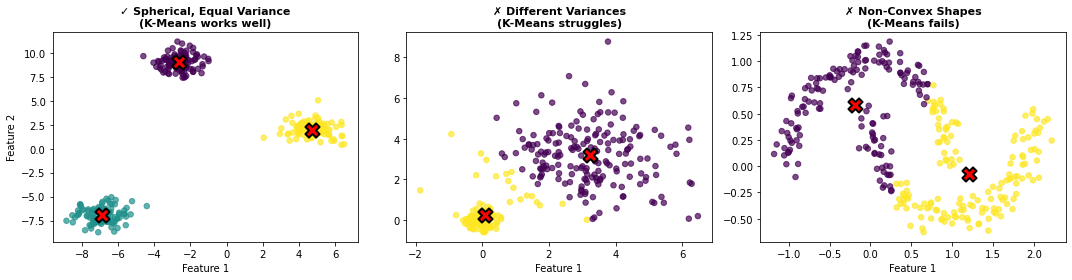

In [1]:
# Visualization: When K-Means assumptions hold vs. when they fail
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import KMeans
from warnings import filterwarnings 
filterwarnings("ignore")

np.random.seed(42)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Case 1: Spherical, equal variance (K-Means works well)
X1, _ = make_blobs(n_samples=300, centers=3, cluster_std=0.8, random_state=42)
km1 = KMeans(n_clusters=3, random_state=42, n_init=10).fit(X1)
axes[0].scatter(X1[:, 0], X1[:, 1], c=km1.labels_, cmap='viridis', s=30, alpha=0.7)
axes[0].scatter(km1.cluster_centers_[:, 0], km1.cluster_centers_[:, 1], 
                c='red', marker='X', s=200, edgecolors='black', linewidths=2)
axes[0].set_title('✓ Spherical, Equal Variance\n(K-Means works well)', fontsize=11, fontweight='bold')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')

# Case 2: Different variances (K-Means struggles)
X2a, _ = make_blobs(n_samples=100, centers=[[0, 0]], cluster_std=0.3, random_state=42)
X2b, _ = make_blobs(n_samples=200, centers=[[3, 3]], cluster_std=1.5, random_state=42)
X2 = np.vstack([X2a, X2b])
km2 = KMeans(n_clusters=2, random_state=42, n_init=10).fit(X2)
axes[1].scatter(X2[:, 0], X2[:, 1], c=km2.labels_, cmap='viridis', s=30, alpha=0.7)
axes[1].scatter(km2.cluster_centers_[:, 0], km2.cluster_centers_[:, 1], 
                c='red', marker='X', s=200, edgecolors='black', linewidths=2)
axes[1].set_title('✗ Different Variances\n(K-Means struggles)', fontsize=11, fontweight='bold')
axes[1].set_xlabel('Feature 1')

# Case 3: Non-convex shapes (K-Means fails)
X3, _ = make_moons(n_samples=300, noise=0.08, random_state=42)
km3 = KMeans(n_clusters=2, random_state=42, n_init=10).fit(X3)
axes[2].scatter(X3[:, 0], X3[:, 1], c=km3.labels_, cmap='viridis', s=30, alpha=0.7)
axes[2].scatter(km3.cluster_centers_[:, 0], km3.cluster_centers_[:, 1], 
                c='red', marker='X', s=200, edgecolors='black', linewidths=2)
axes[2].set_title('✗ Non-Convex Shapes\n(K-Means fails)', fontsize=11, fontweight='bold')
axes[2].set_xlabel('Feature 1')

plt.tight_layout()
plt.show()

---

### Lloyd's Algorithm

The K-Means objective is optimized using **Lloyd's algorithm**, an iterative procedure that alternates between two steps.

#### Step 0: Initialization

Choose $K$ initial centroids $\boldsymbol{\mu}_1^{(0)}, \ldots, \boldsymbol{\mu}_K^{(0)}$.

Common strategies:
- Random selection of $K$ data points
- K-Means++ (smarter initialization, more on this later)

#### Step 1: Assignment Step

Assign each observation to the cluster with the nearest centroid:

$$C_k^{(t)} = \{\mathbf{x}_i : \|\mathbf{x}_i - \boldsymbol{\mu}_k^{(t)}\|^2 \leq \|\mathbf{x}_i - \boldsymbol{\mu}_j^{(t)}\|^2 \text{ for all } j\}$$

#### Step 2: Update Step

Recompute each centroid as the mean of all points assigned to it:

$$\boldsymbol{\mu}_k^{(t+1)} = \frac{1}{|C_k^{(t)}|} \sum_{\mathbf{x}_i \in C_k^{(t)}} \mathbf{x}_i$$

#### Repeat

Iterate Steps 1 and 2 until convergence (assignments no longer change).

Number of Iteration: 6


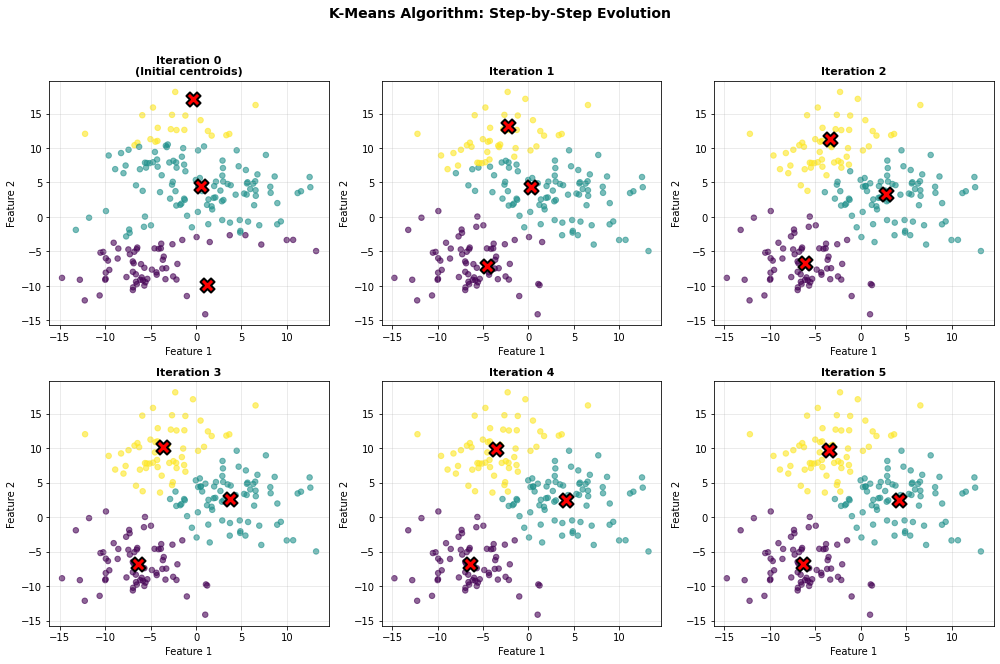

In [2]:
# K-Means iterations
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Generate data
np.random.seed(42)
X, _ = make_blobs(n_samples=200, centers=3, cluster_std=3.7, random_state=42)

# Manual K-Means implementation to show iterations
def kmeans_step_by_step(X, K, max_iter=10, seed=123):
    """Run K-Means and return history of centroids and labels."""
    np.random.seed(seed)
    n = len(X)
    
    # Initialize: random selection of K points
    idx = np.random.choice(n, K, replace=False)
    centroids = X[idx].copy()
    
    history = {'centroids': [centroids.copy()], 'labels': []}
    
    for iteration in range(max_iter):
        # Assignment step
        distances = np.zeros((n, K))
        for k in range(K):
            distances[:, k] = np.sum((X - centroids[k])**2, axis=1)
        labels = np.argmin(distances, axis=1)
        history['labels'].append(labels.copy())
        
        # Update step
        new_centroids = np.zeros_like(centroids)
        for k in range(K):
            if np.sum(labels == k) > 0:
                new_centroids[k] = X[labels == k].mean(axis=0)
            else:
                new_centroids[k] = centroids[k]
        
        # Check convergence
        if np.allclose(centroids, new_centroids):
            break
            
        centroids = new_centroids
        history['centroids'].append(centroids.copy())
    
    return history

# Run K-Means step by step
history = kmeans_step_by_step(X, K=3, max_iter=10)

# Visualize iterations
n_iters = min(6, len(history['centroids']))
fig, axes = plt.subplots(2, 3, figsize=(14, 9))

colors = plt.cm.viridis(np.linspace(0, 1, 3))

for i, ax in enumerate(axes.flat):
    if i < n_iters:
        centroids = history['centroids'][i]
        if i < len(history['labels']):
            labels = history['labels'][i]
            ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=30, alpha=0.6)
        else:
            ax.scatter(X[:, 0], X[:, 1], c='gray', s=30, alpha=0.6)
        
        ax.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', 
                  s=200, edgecolors='black', linewidths=2, zorder=5)
        
        if i == 0:
            ax.set_title(f'Iteration {i}\n(Initial centroids)', fontsize=11, fontweight='bold')
        else:
            ax.set_title(f'Iteration {i}', fontsize=11, fontweight='bold')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.grid(True, alpha=0.3)
print("Number of Iteration:", len(history['centroids']))
plt.suptitle('K-Means Algorithm: Step-by-Step Evolution', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

#### Convergence Properties

Lloyd's algorithm has important convergence properties:

**Guaranteed convergence:** The algorithm always converges in a finite number of iterations. Each step either decreases the objective or leaves it unchanged.

**Local minimum only:** The algorithm converges to a **local minimum**, not necessarily the global optimum. Different initializations can lead to different solutions.

<div style="background-color: #ffebee; padding: 15px; border-left: 5px solid #f44336; margin: 20px 0;">
<strong>⚠️ Critical Warning</strong><br>
K-Means does <strong>not</strong> guarantee finding the global minimum. The solution depends on the initial centroid positions. Always run K-Means multiple times with different initializations and keep the best result.
</div>

---

### Limitations of K-Means

####  Sensitivity to Initialization

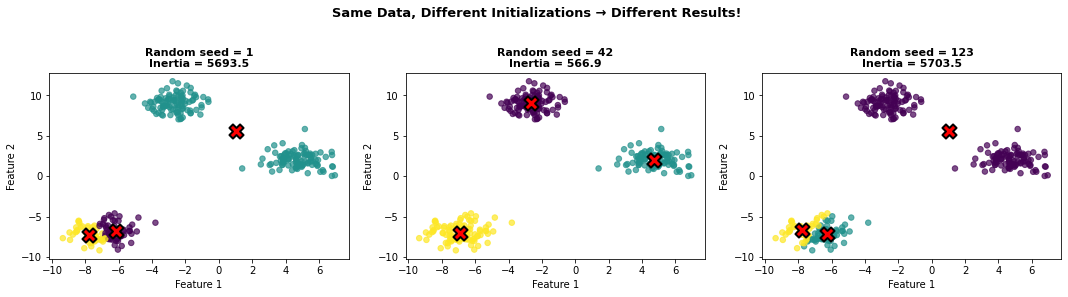

Inertia values: [5693.479286414895, 566.859551124413, 5703.483330134418]
Best initialization: seed=42 with inertia=566.9


In [3]:
# Demonstrate sensitivity to initialization
np.random.seed(42)
X, _ = make_blobs(n_samples=300, centers=3, cluster_std=1.0, random_state=42)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

inertias = []
for i, seed in enumerate([1, 42, 123]):
    km = KMeans(n_clusters=3, random_state=seed, n_init=1, init='random').fit(X)
    inertias.append(km.inertia_)
    
    axes[i].scatter(X[:, 0], X[:, 1], c=km.labels_, cmap='viridis', s=30, alpha=0.7)
    axes[i].scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], 
                    c='red', marker='X', s=200, edgecolors='black', linewidths=2)
    axes[i].set_title(f'Random seed = {seed}\nInertia = {km.inertia_:.1f}', fontsize=11, fontweight='bold')
    axes[i].set_xlabel('Feature 1')
    axes[i].set_ylabel('Feature 2')

plt.suptitle('Same Data, Different Initializations → Different Results!', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"Inertia values: {inertias}")
print(f"Best initialization: seed={[1, 42, 123][np.argmin(inertias)]} with inertia={min(inertias):.1f}")

#### Solution:  K-Means++ Initialization

To mitigate initialization sensitivity, **K-Means++** selects initial centroids that are spread out:

1. Choose the first centroid uniformly at random from the data
2. For each subsequent centroid, choose a point with probability proportional to its squared distance from the nearest existing centroid
3. Repeat until $K$ centroids are selected

This ensures initial centroids are well-separated, leading to better and more consistent results.

### Cannot Handle Non-Convex Clusters

K-Means partitions space using **Voronoi cells** — each point is assigned to the nearest centroid. This creates convex decision boundaries, which fail for non-convex cluster shapes.

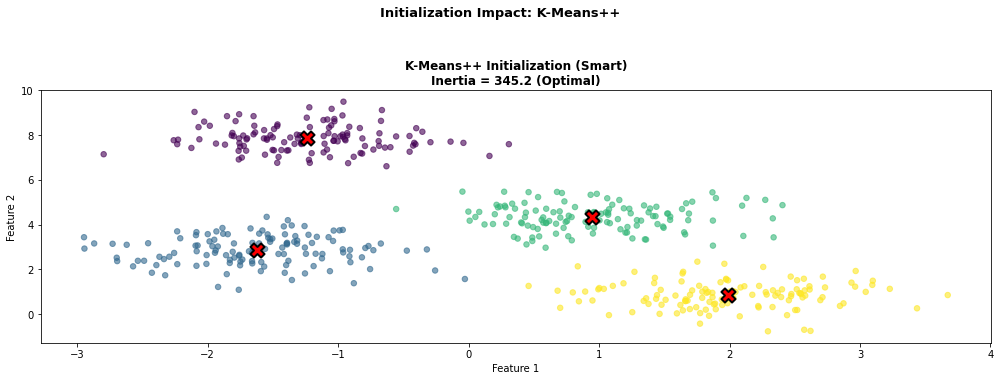

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

# Generate data (4 clusters to make initialization harder)
np.random.seed(0)
X, _ = make_blobs(n_samples=500, centers=4, cluster_std=0.60, random_state=0)

fig, axes = plt.subplots(1, 1, figsize=(14, 5))

# K-Means++ selects initial centers spread out based on probability,
# solving the issue even with a single run (n_init=1).
km_pp = KMeans(n_clusters=4, init='k-means++', n_init=1, random_state=2).fit(X)

axes.scatter(X[:, 0], X[:, 1], c=km_pp.labels_, cmap='viridis', s=30, alpha=0.6)
axes.scatter(km_pp.cluster_centers_[:, 0], km_pp.cluster_centers_[:, 1], 
                c='red', marker='X', s=200, edgecolors='black', linewidths=2)
axes.set_title(f'K-Means++ Initialization (Smart)\nInertia = {km_pp.inertia_:.1f} (Optimal)', 
                  fontsize=12, fontweight='bold')
axes.set_xlabel('Feature 1')
axes.set_ylabel('Feature 2')

plt.suptitle('Initialization Impact: K-Means++', fontsize=13, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

### Sensitive to Outliers

Because centroids are computed as means, outliers can significantly distort cluster centers.

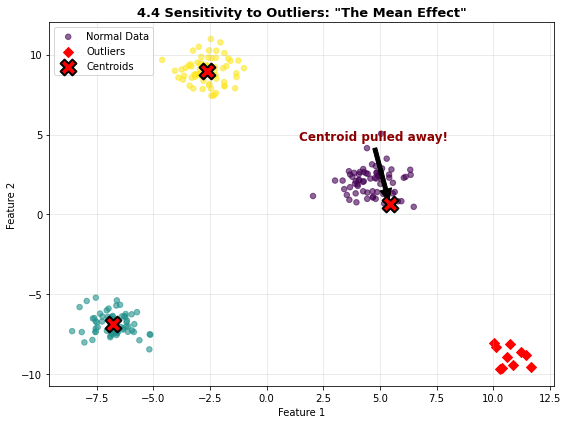

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

np.random.seed(42)
X, _ = make_blobs(n_samples=200, centers=3, cluster_std=0.8, random_state=42)

# 2. Add Outliers (a few points far away)
# We add 10 points very far from the main data clusters
outliers = np.random.uniform(low=[10, -10], high=[12, -8], size=(10, 2))
X_with_outliers = np.vstack([X, outliers])

# 3. Fit K-Means on the contaminated data
km = KMeans(n_clusters=3, random_state=42, n_init=10).fit(X_with_outliers)

plt.figure(figsize=(8, 6))

# Plot normal data points
plt.scatter(X[:, 0], X[:, 1], c=km.labels_[:200], cmap='viridis', s=30, alpha=0.6, label='Normal Data')

# Plot outliers (highlighted)
# Note: we use the labels assigned by K-Means to color them, but mark them differently
plt.scatter(outliers[:, 0], outliers[:, 1], c='red', marker='D', s=50, label='Outliers')

# Plot Centroids
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], 
            c='red', marker='X', s=250, edgecolors='black', linewidths=2, label='Centroids', zorder=10)

# Draw arrow to show the distortion effect
# We identify the centroid closest to outliers and draw an arrow
distorted_centroid_idx = np.argmin(np.linalg.norm(km.cluster_centers_ - outliers.mean(axis=0), axis=1))
distorted_centroid = km.cluster_centers_[distorted_centroid_idx]

plt.annotate('Centroid pulled away!', xy=(distorted_centroid[0], distorted_centroid[1]), 
             xytext=(distorted_centroid[0]-4, distorted_centroid[1]+4),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=12, fontweight='bold', color='darkred')

plt.title('4.4 Sensitivity to Outliers: "The Mean Effect"', fontsize=13, fontweight='bold')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Requires K to be Specified

The number of clusters $K$ must be chosen **before** running the algorithm.

# DBSCAN the Density-Based Clustering

K-Means defines clusters geometrically: points belong to the nearest centroid. But this approach has fundamental limitations:
- Cannot handle non-convex shapes
- Requires specifying $K$ in advance
- Assigns every point to a cluster (no notion of "noise")

**DBSCAN** (Density-Based Spatial Clustering of Applications with Noise) takes a radically different approach:

> A cluster is a **dense region** of points, separated from other clusters by **low-density regions**.

This intuition leads to an algorithm that can:
- Discover clusters of arbitrary shape
- Automatically determine the number of clusters
- Identify outliers (noise points)

### Core Concepts

DBSCAN requires two parameters:

| Parameter | Symbol | Meaning |
|-----------|--------|--------|
| **Epsilon** | $\varepsilon$ | Radius of the neighborhood |
| **MinPts** | $m$ | Minimum points to form a dense region |

### Point Classification

For each point $\mathbf{x}_i$, define its **$\varepsilon$-neighborhood**:

$$N_\varepsilon(\mathbf{x}_i) = \{\mathbf{x}_j \in \mathcal{D} : d(\mathbf{x}_i, \mathbf{x}_j) \leq \varepsilon\}$$

Based on neighborhood size, each point is classified as:

| Type | Condition | Role |
|------|-----------|------|
| **Core point** | $|N_\varepsilon(\mathbf{x}_i)| \geq m$ | Forms the "interior" of clusters |
| **Border point** | Not core, but in $N_\varepsilon$ of a core point | On the "edge" of clusters |
| **Noise point** | Neither core nor border | Outlier, not assigned to any cluster |

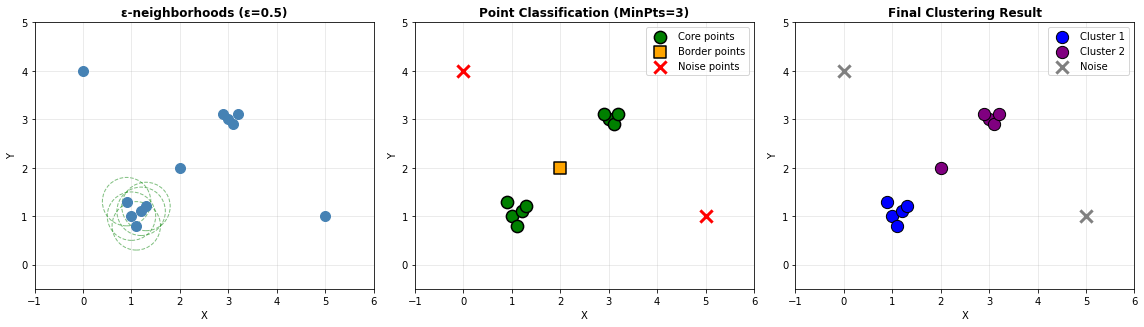

In [6]:
# Visualization of DBSCAN concepts
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

np.random.seed(42)

# Create a small example
points = np.array([
    [1, 1], [1.2, 1.1], [0.9, 1.3], [1.1, 0.8], [1.3, 1.2],  # Dense region 1
    [3, 3], [3.1, 2.9], [2.9, 3.1], [3.2, 3.1],              # Dense region 2
    [2, 2],                                                    # Border point
    [5, 1], [0, 4]                                            # Noise points
])

eps = 0.5
min_pts = 3

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Panel 1: Points with epsilon neighborhoods for core points
ax = axes[0]
ax.scatter(points[:, 0], points[:, 1], s=100, c='steelblue', zorder=3)

# Draw epsilon neighborhoods for first cluster's core
for i in range(5):
    circle = Circle(points[i], eps, fill=False, color='green', linestyle='--', alpha=0.5)
    ax.add_patch(circle)

ax.set_xlim(-1, 6)
ax.set_ylim(-0.5, 5)
ax.set_aspect('equal')
ax.set_title(f'ε-neighborhoods (ε={eps})', fontsize=12, fontweight='bold')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.grid(True, alpha=0.3)

# Panel 2: Point classification
ax = axes[1]

# Manually classify for this example
core_idx = [0, 1, 2, 3, 4, 5, 6, 7, 8]  # Points with >= 3 neighbors within eps
border_idx = [9]  # Near a core but not enough neighbors
noise_idx = [10, 11]  # Isolated

# For visualization, simplify:
core_points = points[:5]  # First cluster cores
core_points2 = points[5:9]  # Second cluster cores
border_point = points[9:10]
noise_points = points[10:]

ax.scatter(core_points[:, 0], core_points[:, 1], s=150, c='green', marker='o', 
           label='Core points', zorder=3, edgecolors='black', linewidths=1.5)
ax.scatter(core_points2[:, 0], core_points2[:, 1], s=150, c='green', marker='o', zorder=3,
           edgecolors='black', linewidths=1.5)
ax.scatter(border_point[:, 0], border_point[:, 1], s=150, c='orange', marker='s', 
           label='Border points', zorder=3, edgecolors='black', linewidths=1.5)
ax.scatter(noise_points[:, 0], noise_points[:, 1], s=150, c='red', marker='x', 
           label='Noise points', zorder=3, linewidths=3)

ax.set_xlim(-1, 6)
ax.set_ylim(-0.5, 5)
ax.set_aspect('equal')
ax.set_title(f'Point Classification (MinPts={min_pts})', fontsize=12, fontweight='bold')
ax.legend(loc='upper right')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.grid(True, alpha=0.3)

# Panel 3: Final clusters
ax = axes[2]
ax.scatter(points[:5, 0], points[:5, 1], s=150, c='blue', label='Cluster 1', 
           zorder=3, edgecolors='black', linewidths=1)
ax.scatter(points[5:9, 0], points[5:9, 1], s=150, c='purple', label='Cluster 2', 
           zorder=3, edgecolors='black', linewidths=1)
ax.scatter(points[9, 0], points[9, 1], s=150, c='purple', zorder=3,  # Border assigned to nearest
           edgecolors='black', linewidths=1)
ax.scatter(noise_points[:, 0], noise_points[:, 1], s=150, c='gray', marker='x', 
           label='Noise', zorder=3, linewidths=3)

ax.set_xlim(-1, 6)
ax.set_ylim(-0.5, 5)
ax.set_aspect('equal')
ax.set_title('Final Clustering Result', fontsize=12, fontweight='bold')
ax.legend(loc='upper right')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Density Reachability

Two key concepts define how clusters are formed:

**Directly density-reachable:** Point $\mathbf{x}_j$ is directly density-reachable from $\mathbf{x}_i$ if:
- $\mathbf{x}_i$ is a core point
- $\mathbf{x}_j \in N_\varepsilon(\mathbf{x}_i)$

**Density-reachable:** Point $\mathbf{x}_j$ is density-reachable from $\mathbf{x}_i$ if there exists a chain of points $\mathbf{x}_i = \mathbf{p}_1, \mathbf{p}_2, \ldots, \mathbf{p}_n = \mathbf{x}_j$ where each $\mathbf{p}_{k+1}$ is directly density-reachable from $\mathbf{p}_k$.

### Algorithm Steps

```
1. For each unvisited point p:
   a. Mark p as visited
   b. Find N_ε(p) — all points within ε distance
   c. If |N_ε(p)| < MinPts:
      - Mark p as NOISE (may change later)
   d. Else:
      - Start a new cluster C
      - Add p to C
      - For each point q in N_ε(p):
        - If q is unvisited, mark visited and check its neighborhood
        - If q is not yet in any cluster, add q to C
2. Return all clusters and noise points
```

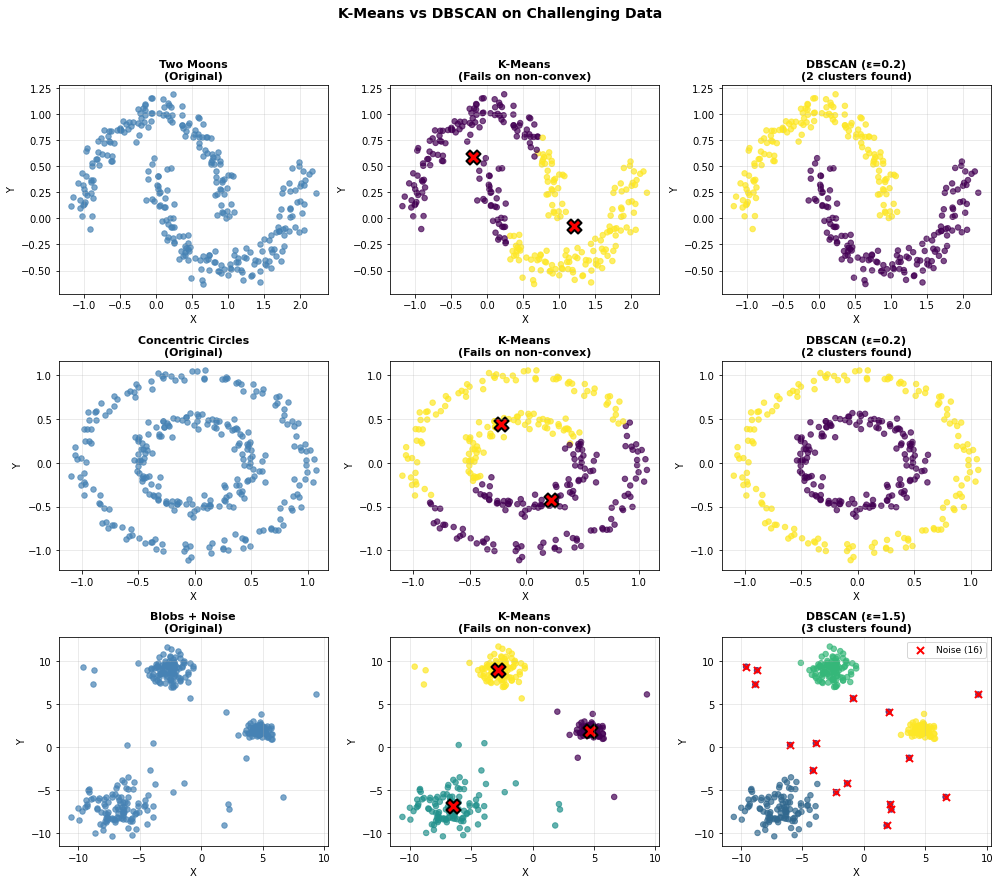

In [7]:
# DBSCAN on challenging data where K-Means fails
from sklearn.cluster import DBSCAN, KMeans
from sklearn.datasets import make_moons, make_circles, make_blobs

np.random.seed(42)

# Create challenging datasets
X_moons, _ = make_moons(n_samples=300, noise=0.08, random_state=42)
X_circles, _ = make_circles(n_samples=300, noise=0.05, factor=0.5, random_state=42)
X_blobs, _ = make_blobs(n_samples=300, centers=3, cluster_std=[1.0, 0.5, 1.5], random_state=42)
# Add some noise points to blobs
X_blobs = np.vstack([X_blobs, np.random.uniform(-10, 10, size=(20, 2))])

datasets = [
    (X_moons, 'Two Moons'),
    (X_circles, 'Concentric Circles'),
    (X_blobs, 'Blobs + Noise')
]

fig, axes = plt.subplots(3, 3, figsize=(14, 12))

for row, (X, name) in enumerate(datasets):
    # Original data
    axes[row, 0].scatter(X[:, 0], X[:, 1], s=30, c='steelblue', alpha=0.7)
    axes[row, 0].set_title(f'{name}\n(Original)', fontsize=11, fontweight='bold')
    
    # K-Means
    km = KMeans(n_clusters=2 if row < 2 else 3, random_state=42, n_init=10).fit(X)
    axes[row, 1].scatter(X[:, 0], X[:, 1], c=km.labels_, cmap='viridis', s=30, alpha=0.7)
    axes[row, 1].scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
                         c='red', marker='X', s=200, edgecolors='black', linewidths=2)
    axes[row, 1].set_title('K-Means\n(Fails on non-convex)', fontsize=11, fontweight='bold')
    
    # DBSCAN
    eps_vals = [0.2, 0.2, 1.5]  # Tuned for each dataset
    db = DBSCAN(eps=eps_vals[row], min_samples=5).fit(X)
    
    # Color noise points differently
    colors = db.labels_.copy().astype(float)
    colors[db.labels_ == -1] = -1  # Noise
    
    scatter = axes[row, 2].scatter(X[:, 0], X[:, 1], c=colors, cmap='viridis', s=30, alpha=0.7)
    # Mark noise points
    noise_mask = db.labels_ == -1
    if noise_mask.sum() > 0:
        axes[row, 2].scatter(X[noise_mask, 0], X[noise_mask, 1], c='red', marker='x', 
                            s=50, linewidths=2, label=f'Noise ({noise_mask.sum()})')
        axes[row, 2].legend(loc='upper right', fontsize=9)
    
    n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
    axes[row, 2].set_title(f'DBSCAN (ε={eps_vals[row]})\n({n_clusters} clusters found)', 
                          fontsize=11, fontweight='bold')

for ax in axes.flat:
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.grid(True, alpha=0.3)

plt.suptitle('K-Means vs DBSCAN on Challenging Data', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### Choosing Parameters: ε and MinPts

#### The k-Distance Graph

A useful heuristic for choosing $\varepsilon$:

1. Choose $k$ = MinPts (or MinPts - 1)
2. For each point, compute the distance to its $k$-th nearest neighbor
3. Sort these distances in ascending order and plot
4. Look for an "elbow" — the point where distances sharply increase

The intuition: points within clusters have small $k$-distances, while noise points have large $k$-distances. The elbow indicates a good threshold.

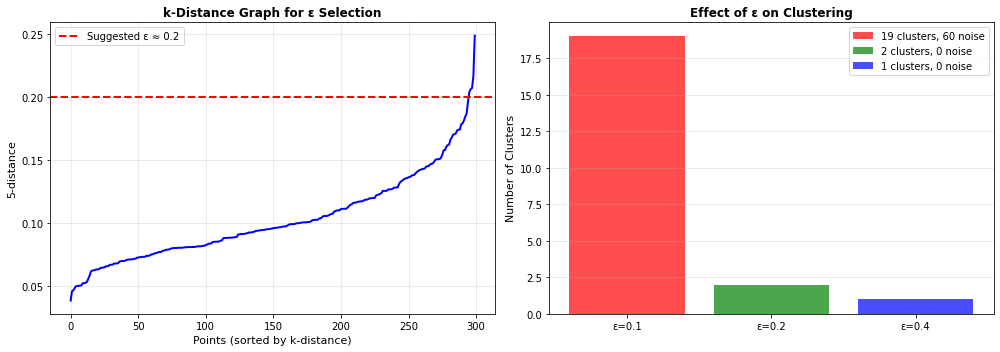

In [8]:
# k-distance graph for parameter selection
from sklearn.neighbors import NearestNeighbors

X = X_moons  # Use moons dataset

# Compute k-distances
k = 5  # MinPts - 1
nn = NearestNeighbors(n_neighbors=k)
nn.fit(X)
distances, _ = nn.kneighbors(X)

# k-th neighbor distance for each point
k_distances = distances[:, -1]
k_distances_sorted = np.sort(k_distances)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# k-distance graph
ax = axes[0]
ax.plot(range(len(k_distances_sorted)), k_distances_sorted, 'b-', linewidth=2)
ax.axhline(y=0.2, color='red', linestyle='--', linewidth=2, label='Suggested ε ≈ 0.2')
ax.set_xlabel('Points (sorted by k-distance)', fontsize=11)
ax.set_ylabel(f'{k}-distance', fontsize=11)
ax.set_title('k-Distance Graph for ε Selection', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Effect of different ε values
ax = axes[1]
eps_values = [0.1, 0.2, 0.4]
colors = ['red', 'green', 'blue']

for eps, color in zip(eps_values, colors):
    db = DBSCAN(eps=eps, min_samples=5).fit(X)
    n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
    n_noise = (db.labels_ == -1).sum()
    ax.bar(f'ε={eps}', n_clusters, color=color, alpha=0.7, label=f'{n_clusters} clusters, {n_noise} noise')

ax.set_ylabel('Number of Clusters', fontsize=11)
ax.set_title('Effect of ε on Clustering', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Guidelines for MinPts

Common heuristics:
- **MinPts ≥ d + 1** (where $d$ is dimensionality)
- **MinPts ≥ 2 × d** is often recommended
- For 2D data: MinPts = 4 is a common starting point
- Larger MinPts → more robust to noise, but may merge distinct clusters



| Advantage | Explanation |
|-----------|-------------|
| **Arbitrary shapes** | Can discover non-convex, elongated clusters |
| **No K required** | Number of clusters emerges from the data |
| **Noise handling** | Explicitly identifies outliers |
| **Single scan** | Efficient: O(n log n) with spatial indexing |

| Limitation | Explanation |
|------------|-------------|
| **Parameter sensitivity** | Results depend heavily on ε and MinPts |
| **Varying densities** | Struggles when clusters have different densities |
| **High dimensionality** | Curse of dimensionality affects neighborhood queries |
| **Border points** | Arbitrarily assigned when between clusters |

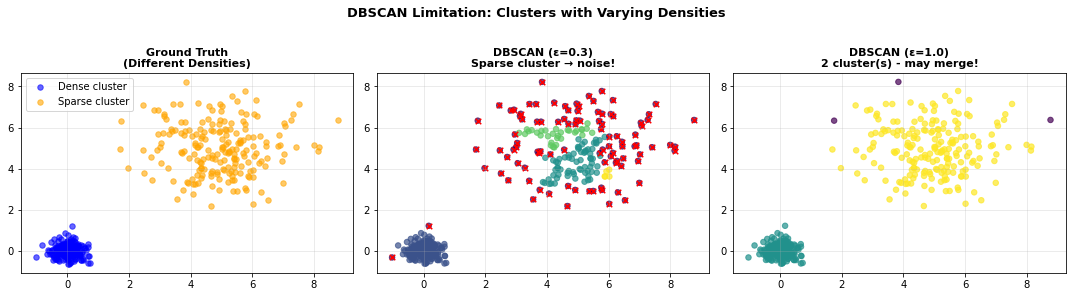

In [9]:
# DBSCAN limitation: varying density clusters
np.random.seed(42)

# Create clusters with very different densities
dense_cluster = np.random.multivariate_normal([0, 0], [[0.1, 0], [0, 0.1]], 200)
sparse_cluster = np.random.multivariate_normal([5, 5], [[1.5, 0], [0, 1.5]], 200)
X_varying = np.vstack([dense_cluster, sparse_cluster])

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Original data
ax = axes[0]
ax.scatter(X_varying[:200, 0], X_varying[:200, 1], s=30, c='blue', alpha=0.6, label='Dense cluster')
ax.scatter(X_varying[200:, 0], X_varying[200:, 1], s=30, c='orange', alpha=0.6, label='Sparse cluster')
ax.set_title('Ground Truth\n(Different Densities)', fontsize=11, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# DBSCAN with small ε (good for dense, misses sparse)
ax = axes[1]
db_small = DBSCAN(eps=0.3, min_samples=5).fit(X_varying)
ax.scatter(X_varying[:, 0], X_varying[:, 1], c=db_small.labels_, cmap='viridis', s=30, alpha=0.7)
noise_mask = db_small.labels_ == -1
ax.scatter(X_varying[noise_mask, 0], X_varying[noise_mask, 1], c='red', marker='x', s=30)
ax.set_title(f'DBSCAN (ε=0.3)\nSparse cluster → noise!', fontsize=11, fontweight='bold')
ax.grid(True, alpha=0.3)

# DBSCAN with large ε (good for sparse, merges dense)
ax = axes[2]
db_large = DBSCAN(eps=1.0, min_samples=5).fit(X_varying)
ax.scatter(X_varying[:, 0], X_varying[:, 1], c=db_large.labels_, cmap='viridis', s=30, alpha=0.7)
n_clusters = len(set(db_large.labels_)) - (1 if -1 in db_large.labels_ else 0)
ax.set_title(f'DBSCAN (ε=1.0)\n{n_clusters} cluster(s) - may merge!', fontsize=11, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.suptitle('DBSCAN Limitation: Clusters with Varying Densities', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### The solution for the above issue is use HDBSCAN (Hierarchical DBSCAN) which performs DBSCAN over varying epsilon values and integrates the result to find a clustering that gives the best stability.

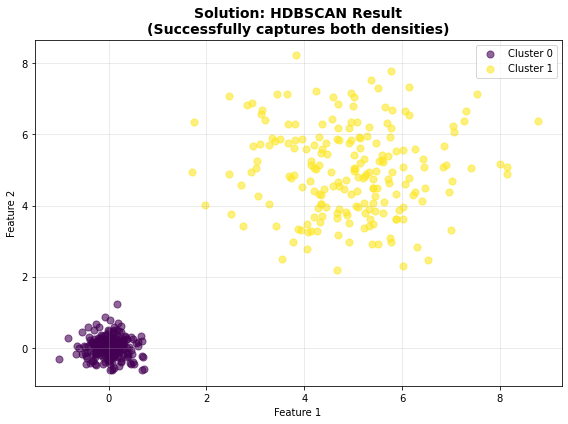

HDBSCAN found 2 clusters.


In [10]:
from sklearn.cluster import HDBSCAN

# 1. Fit the model
# We don't need to guess 'eps'. We only specify the minimum size of a cluster.
hdb = HDBSCAN(min_cluster_size=15)
labels_hdb = hdb.fit_predict(X_varying)

# 2. Visualize the result
plt.figure(figsize=(8, 6))

unique_labels = set(labels_hdb)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(sorted(unique_labels), colors):
    mask = labels_hdb == k
    if k == -1:
        # Plot Noise (Outliers)
        plt.scatter(X_varying[mask, 0], X_varying[mask, 1], c='red', marker='x', s=50, label='Noise')
    else:
        # Plot Clusters
        plt.scatter(X_varying[mask, 0], X_varying[mask, 1], c=[col], s=50, alpha=0.6, label=f'Cluster {k}')

plt.title('Solution: HDBSCAN Result\n(Successfully captures both densities)', fontsize=14, fontweight='bold')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary
n_clusters = len(set(labels_hdb)) - (1 if -1 in labels_hdb else 0)
print(f"HDBSCAN found {n_clusters} clusters.")

---

#  Gaussian Mixture Models

---

## Probabilistic Clustering

K-Means makes **hard assignments**: each point belongs to exactly one cluster. But what if we are uncertain about cluster membership? What if a point lies between two clusters?

**Gaussian Mixture Models (GMM)** take a probabilistic approach:
- Each cluster is modeled as a Gaussian (normal) distribution
- Each point has a **probability** of belonging to each cluster
- This is called **soft clustering**

### The Generative Model

GMM assumes the data was generated by the following process:

1. For each observation $\mathbf{x}_i$:
   - First, randomly select a cluster $k$ with probability $\pi_k$
   - Then, generate $\mathbf{x}_i$ from the Gaussian distribution $\mathcal{N}(\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)$

The overall density is a **mixture of Gaussians**:

$$p(\mathbf{x}) = \sum_{k=1}^{K} \pi_k \, \mathcal{N}(\mathbf{x} \mid \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)$$

where:
- $\pi_k$ are the **mixing coefficients** (prior probability of each cluster), with $\sum_k \pi_k = 1$
- $\boldsymbol{\mu}_k$ is the mean of cluster $k$
- $\boldsymbol{\Sigma}_k$ is the covariance matrix of cluster $k$
- $\mathcal{N}(\mathbf{x} \mid \boldsymbol{\mu}, \boldsymbol{\Sigma})$ is the multivariate Gaussian density

### The Multivariate Gaussian

Recall that the multivariate Gaussian density is:

$$\mathcal{N}(\mathbf{x} \mid \boldsymbol{\mu}, \boldsymbol{\Sigma}) = \frac{1}{(2\pi)^{d/2} |\boldsymbol{\Sigma}|^{1/2}} \exp\left( -\frac{1}{2}(\mathbf{x} - \boldsymbol{\mu})^\top \boldsymbol{\Sigma}^{-1} (\mathbf{x} - \boldsymbol{\mu}) \right)$$

Note the term $(\mathbf{x} - \boldsymbol{\mu})^\top \boldsymbol{\Sigma}^{-1} (\mathbf{x} - \boldsymbol{\mu})$ — this is exactly the **squared Mahalanobis distance** from Lecture 1!

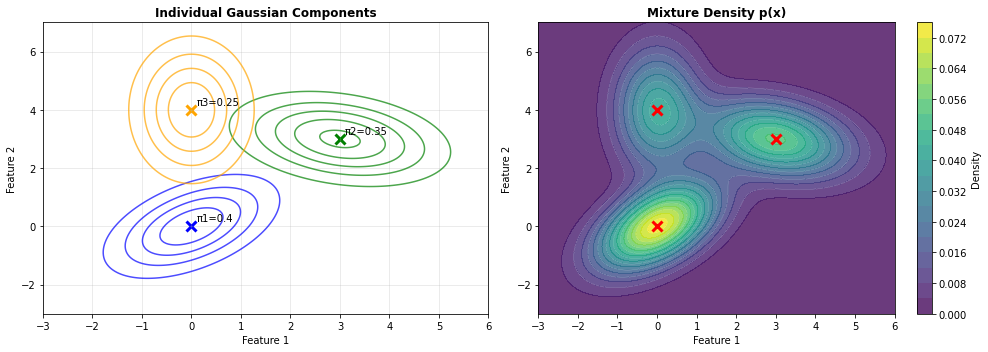

In [11]:
# Visualization: Mixture of Gaussians
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Define three Gaussian components
components = [
    {'mean': [0, 0], 'cov': [[1, 0.5], [0.5, 1]], 'pi': 0.4},
    {'mean': [3, 3], 'cov': [[1.5, -0.3], [-0.3, 0.8]], 'pi': 0.35},
    {'mean': [0, 4], 'cov': [[0.5, 0], [0, 2]], 'pi': 0.25}
]

# Create grid
x = np.linspace(-3, 6, 200)
y = np.linspace(-3, 7, 200)
X_grid, Y_grid = np.meshgrid(x, y)
pos = np.dstack((X_grid, Y_grid))

# Compute mixture density
Z_mixture = np.zeros_like(X_grid)
Z_components = []

for comp in components:
    rv = multivariate_normal(comp['mean'], comp['cov'])
    Z_k = comp['pi'] * rv.pdf(pos)
    Z_components.append(Z_k)
    Z_mixture += Z_k

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Individual components
ax = axes[0]
colors = ['blue', 'green', 'orange']
for i, (Z_k, comp, color) in enumerate(zip(Z_components, components, colors)):
    ax.contour(X_grid, Y_grid, Z_k, levels=5, colors=color, alpha=0.7)
    ax.scatter(*comp['mean'], c=color, s=100, marker='x', linewidths=3)
    ax.annotate(f'π{i+1}={comp["pi"]}', xy=comp['mean'], xytext=(5, 5), 
                textcoords='offset points', fontsize=10)
ax.set_title('Individual Gaussian Components', fontsize=12, fontweight='bold')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.grid(True, alpha=0.3)

# Mixture density
ax = axes[1]
contour = ax.contourf(X_grid, Y_grid, Z_mixture, levels=20, cmap='viridis', alpha=0.8)
ax.contour(X_grid, Y_grid, Z_mixture, levels=10, colors='white', linewidths=0.5, alpha=0.5)
for comp, color in zip(components, colors):
    ax.scatter(*comp['mean'], c='red', s=100, marker='x', linewidths=3, zorder=5)
ax.set_title('Mixture Density p(x)', fontsize=12, fontweight='bold')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
plt.colorbar(contour, ax=ax, label='Density')

plt.tight_layout()
plt.show()

### Soft vs Hard Clustering

In GMM, each point has a **responsibility** $\gamma_{ik}$ representing the probability that point $\mathbf{x}_i$ belongs to cluster $k$:

$$\gamma_{ik} = P(z_k = 1 \mid \mathbf{x}_i)$$

where $z_k$ is a latent (hidden) variable indicating cluster membership.

A point near the boundary between two clusters might have $\gamma_{i1} = 0.6$ and $\gamma_{i2} = 0.4$ — it's uncertain, and GMM quantifies this uncertainty.

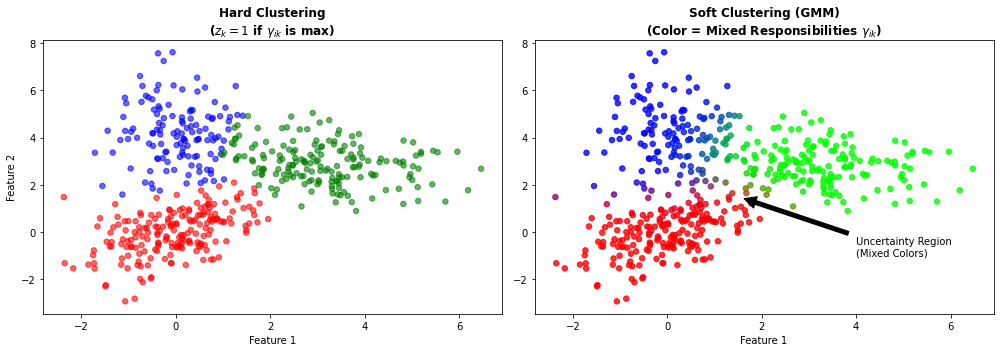

In [12]:
# Visualization: Hard vs. Soft Clustering (Responsibilities)

# 1. Generate synthetic data from your defined components
np.random.seed(42)
n_samples = 500
X_data = []
true_labels = []

# Generate points based on component weights (pi)
for i, comp in enumerate(components):
    n_k = int(n_samples * comp['pi'])
    # Generate points from multivariate normal
    pts = np.random.multivariate_normal(comp['mean'], comp['cov'], n_k)
    X_data.append(pts)
    true_labels.append(np.full(n_k, i))

X_data = np.vstack(X_data)
true_labels = np.concatenate(true_labels)

# 2. Calculate Responsibilities (Gamma) manually using Bayes' Theorem
# gamma_ik = (pi_k * N(x|mu_k, cov_k)) / sum(pi_j * N(x|mu_j, cov_j))
responsibilities = np.zeros((len(X_data), 3))

for i, comp in enumerate(components):
    rv = multivariate_normal(comp['mean'], comp['cov'])
    # Numerator for each class
    responsibilities[:, i] = comp['pi'] * rv.pdf(X_data)

# Normalize rows to sum to 1 (Denominator)
responsibilities /= responsibilities.sum(axis=1, keepdims=True)

# 3. Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Hard Clustering (Argmax)
# We assign each point solely to the component with highest probability
hard_labels = np.argmax(responsibilities, axis=1)
colors_hard = np.array(['red', 'green', 'blue'])

axes[0].scatter(X_data[:, 0], X_data[:, 1], c=colors_hard[hard_labels], s=30, alpha=0.6)
axes[0].set_title('Hard Clustering\n($z_k = 1$ if $\gamma_{ik}$ is max)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')

# Plot 2: Soft Clustering (RGB Mixing)
# We mix colors based on responsibilities. 
# If a point is 50% Red and 50% Green, it will appear Yellow/Brown.
# Red=[1,0,0], Green=[0,1,0], Blue=[0,0,1]
base_colors = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]) # RGB for 3 components
soft_colors = responsibilities @ base_colors # Matrix multiplication to mix colors

axes[1].scatter(X_data[:, 0], X_data[:, 1], c=soft_colors, s=30, alpha=0.8)
axes[1].set_title('Soft Clustering (GMM)\n(Color = Mixed Responsibilities $\gamma_{ik}$)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Feature 1')

# Add definition of uncertainty
axes[1].annotate('Uncertainty Region\n(Mixed Colors)', xy=(1.5, 1.5), xytext=(4, -1),
                 arrowprops=dict(facecolor='black', shrink=0.05), fontsize=10)

plt.tight_layout()
plt.show()

---

## The EM Algorithm

GMM parameters cannot be estimated in closed form. Instead, we use the **Expectation-Maximization (EM)** algorithm, which iteratively refines our estimates.

### E-Step (Expectation)

Compute the **responsibilities** — the posterior probability that each point belongs to each cluster:

$$\gamma_{ik} = \frac{\pi_k \, \mathcal{N}(\mathbf{x}_i \mid \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)}{\sum_{j=1}^{K} \pi_j \, \mathcal{N}(\mathbf{x}_i \mid \boldsymbol{\mu}_j, \boldsymbol{\Sigma}_j)}$$

This is simply Bayes' theorem! The numerator is "how likely is this point under cluster $k$", and the denominator normalizes across all clusters.

### M-Step (Maximization)

Update the parameters using the responsibilities as "soft" cluster assignments:

**Effective cluster size:**
$$N_k = \sum_{i=1}^{n} \gamma_{ik}$$

**Update means:**
$$\boldsymbol{\mu}_k^{\text{new}} = \frac{1}{N_k} \sum_{i=1}^{n} \gamma_{ik} \, \mathbf{x}_i$$

**Update covariances:**
$$\boldsymbol{\Sigma}_k^{\text{new}} = \frac{1}{N_k} \sum_{i=1}^{n} \gamma_{ik} \, (\mathbf{x}_i - \boldsymbol{\mu}_k^{\text{new}})(\mathbf{x}_i - \boldsymbol{\mu}_k^{\text{new}})^\top$$

**Update mixing coefficients:**
$$\pi_k^{\text{new}} = \frac{N_k}{n}$$

### Understanding EM Intuitively

The EM algorithm can be understood as a "soft" version of K-Means:

| K-Means | EM for GMM |
|---------|------------|
| Assign each point to ONE cluster | Compute probability for ALL clusters |
| Centroid = mean of assigned points | Mean = weighted average (weights = responsibilities) |
| All clusters have same (implicit) variance | Each cluster has its own covariance matrix |

In fact, K-Means can be viewed as a special case of GMM where:
- All covariances are $\sigma^2 \mathbf{I}$ (spherical, equal variance)
- We take the limit as $\sigma \to 0$ (hard assignments)

<div style="background-color: #e8f5e9; padding: 15px; border-left: 5px solid #4CAF50; margin: 20px 0;">
<strong>💡 Key Insight</strong><br>
You don't need to memorize all the update formulas. The important thing is to understand the <strong>mechanism</strong>:
<ol>
<li><strong>E-step:</strong> Given current parameters, compute how much each cluster "owns" each point</li>
<li><strong>M-step:</strong> Given these soft assignments, update parameters as weighted averages</li>
</ol>
</div>

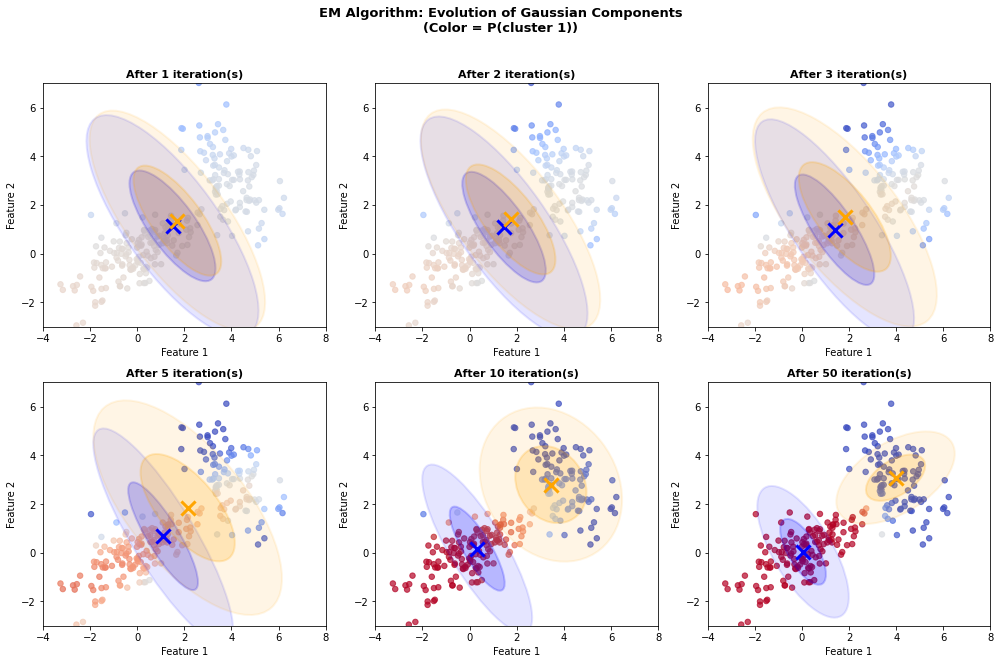

In [13]:
# Visualize EM iterations
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse

# Generate data with elliptical clusters
np.random.seed(42)
n1 = 150
n2 = 100
X1 = np.random.multivariate_normal([0, 0], [[2, 1], [1, 1]], n1)
X2 = np.random.multivariate_normal([4, 3], [[1, -0.5], [-0.5, 1.5]], n2)
X = np.vstack([X1, X2])

def draw_ellipse(ax, mean, cov, color, alpha=0.3):
    """Draw ellipse representing Gaussian component."""
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(eigenvectors[1, 1], eigenvectors[0, 1]))
    for n_std in [1, 2]:
        width = 2 * n_std * np.sqrt(eigenvalues[0])
        height = 2 * n_std * np.sqrt(eigenvalues[1])
        ellipse = Ellipse(mean, width, height, angle=angle, 
                         fill=True, alpha=alpha/n_std, color=color, linewidth=2)
        ax.add_patch(ellipse)

# Run GMM with different numbers of iterations
fig, axes = plt.subplots(2, 3, figsize=(14, 9))

max_iters = [1, 2, 3, 5, 10, 50]
colors = ['blue', 'orange']

for ax, n_iter in zip(axes.flat, max_iters):
    gmm = GaussianMixture(n_components=2, max_iter=n_iter, n_init=1, 
                          random_state=42, init_params='random')
    gmm.fit(X)
    
    # Get responsibilities
    responsibilities = gmm.predict_proba(X)
    
    # Color by dominant cluster
    ax.scatter(X[:, 0], X[:, 1], c=responsibilities[:, 0], cmap='coolwarm', 
               s=30, alpha=0.7, vmin=0, vmax=1)
    
    # Draw Gaussian ellipses
    for k in range(2):
        draw_ellipse(ax, gmm.means_[k], gmm.covariances_[k], colors[k], alpha=0.2)
        ax.scatter(*gmm.means_[k], c=colors[k], marker='x', s=200, linewidths=3, zorder=5)
    
    ax.set_title(f'After {n_iter} iteration(s)', fontsize=11, fontweight='bold')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_xlim(-4, 8)
    ax.set_ylim(-3, 7)

plt.suptitle('EM Algorithm: Evolution of Gaussian Components\n(Color = P(cluster 1))', 
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---

## Comparison: K-Means vs GMM

| **Aspect**                        | **K-Means**                                          | **DBSCAN**                                            | **Gaussian Mixture Models (GMM)**                    |
| --------------------------------- | ---------------------------------------------------- | ----------------------------------------------------- | ---------------------------------------------------- |
| **Core idea**                     | Partition data by minimizing within-cluster distance | Identify dense regions separated by low-density areas | Model data as a mixture of probability distributions |
| **Assignment**                    | Hard assignment                                      | Hard assignment (noise explicitly identified)         | Soft assignment (posterior probabilities)            |
| **Model nature**                  | Geometric, distance-based                            | Density-based, neighborhood-based                     | Probabilistic, generative                            |
| **Key assumption**                | Clusters are compact and roughly spherical           | Clusters correspond to regions of high density        | Data are generated by Gaussian components            |
| **Cluster shape**                 | Spherical (implicit)                                 | Arbitrary (density-connected regions)                 | Elliptical (covariance structure)                    |
| **Number of clusters**            | Must be specified in advance                         | Inferred from data                                    | Must be specified (or selected via model selection)  |
| **Noise / outliers**              | Forced assignment to a cluster                       | Explicitly labeled as noise                           | Low likelihood points (implicit anomalies)           |
| **Variance modeling**             | Fixed and equal across clusters                      | Not explicitly modeled                                | Estimated per cluster                                |
| **Sensitivity to scaling**        | High                                                 | Very high (ε is scale-dependent)                      | High (covariance estimation affected)                |
| **Sensitivity to dimensionality** | High                                                 | Very high (density becomes ill-defined)               | High (covariance estimation unstable)                |
| **Computational cost**            | Low                                                  | Moderate                                              | Higher                                               |
| **Flexibility**                   | Limited                                              | High for irregular shapes                             | High but model-dependent                             |
| **Output**                        | Cluster labels + centroids                           | Cluster labels + noise points                         | Probabilities, labels, full density model            |
| **Interpretability**              | Centroids as prototypes                              | Clusters as dense regions                             | Probabilistic interpretation with uncertainty        |
<!--  -->

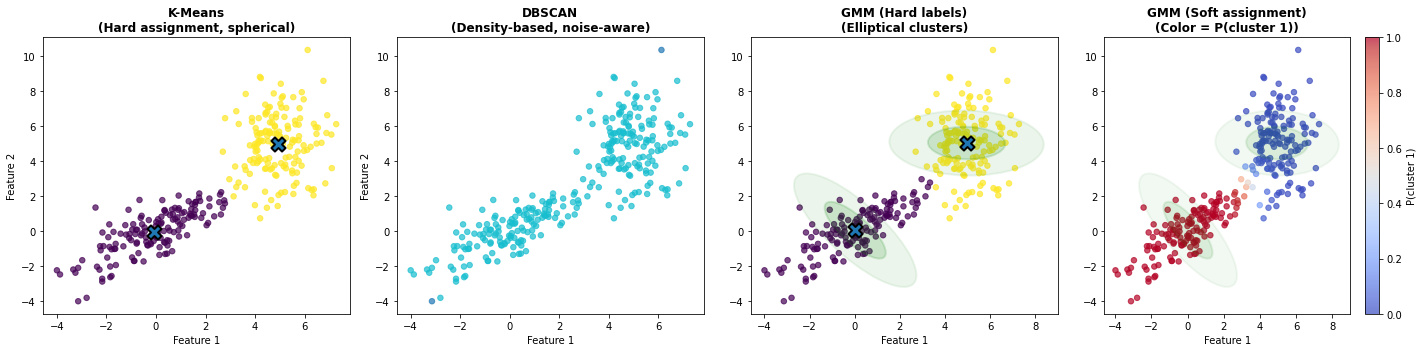

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

# --------------------------------------------------
# Data with elliptical clusters (challenging scenario)
# --------------------------------------------------
np.random.seed(42)
X1 = np.random.multivariate_normal([0, 0], [[3, 2], [2, 2]], 150)
X2 = np.random.multivariate_normal([5, 5], [[1, 0], [0, 3]], 150)
X = np.vstack([X1, X2])

# DBSCAN is scale-sensitive → scale explicitly
X_scaled = StandardScaler().fit_transform(X)

# --------------------------------------------------
# Fit models
# --------------------------------------------------
km = KMeans(n_clusters=2, random_state=42, n_init=10).fit(X)
db = DBSCAN(eps=0.5, min_samples=5).fit(X_scaled)
gmm = GaussianMixture(n_components=2, random_state=42, n_init=5).fit(X)

# --------------------------------------------------
# Plot
# --------------------------------------------------
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# --- K-Means ---
ax = axes[0]
ax.scatter(X[:, 0], X[:, 1], c=km.labels_, cmap='viridis', s=30, alpha=0.7)
ax.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
           marker='X', s=200, edgecolors='black', linewidths=2)
ax.set_title('K-Means\n(Hard assignment, spherical)', fontsize=12, fontweight='bold')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')

# --- DBSCAN ---
ax = axes[1]
db_labels = db.labels_
ax.scatter(X[:, 0], X[:, 1], c=db_labels, cmap='tab10', s=30, alpha=0.7)
ax.set_title('DBSCAN\n(Density-based, noise-aware)', fontsize=12, fontweight='bold')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')

# --- GMM (hard labels) ---
ax = axes[2]
gmm_labels = gmm.predict(X)
ax.scatter(X[:, 0], X[:, 1], c=gmm_labels, cmap='viridis', s=30, alpha=0.7)
for k in range(2):
    draw_ellipse(ax, gmm.means_[k], gmm.covariances_[k],
                 alpha=0.15, color='green')
ax.scatter(gmm.means_[:, 0], gmm.means_[:, 1],
           marker='X', s=200, edgecolors='black', linewidths=2)
ax.set_title('GMM (Hard labels)\n(Elliptical clusters)', fontsize=12, fontweight='bold')
ax.set_xlabel('Feature 1')

# --- GMM (soft probabilities) ---
ax = axes[3]
probs = gmm.predict_proba(X)
scatter = ax.scatter(X[:, 0], X[:, 1], c=probs[:, 0],
                     cmap='coolwarm', s=30, alpha=0.7, vmin=0, vmax=1)
for k in range(2):
    draw_ellipse(ax, gmm.means_[k], gmm.covariances_[k],
                 alpha=0.1, color = 'green')
ax.set_title('GMM (Soft assignment)\n(Color = P(cluster 1))',
             fontsize=12, fontweight='bold')
ax.set_xlabel('Feature 1')
plt.colorbar(scatter, ax=ax, label='P(cluster 1)')

plt.tight_layout()
plt.show()


There is no single “true” clustering of the data.
Different algorithms answer different questions:

- K-Means: which points are closest in space?

- DBSCAN: where is the data density high?

- GMM: which probabilistic model most likely generated the data?

---

#  Choosing the Number of Clusters

---

## Methods for Selecting K

Both K-Means and GMM require specifying the number of clusters $K$. How do we choose?

### The Elbow Method (K-Means)

Plot the within-cluster sum of squares (inertia) against $K$. Look for an "elbow" — a point where adding more clusters yields diminishing returns.

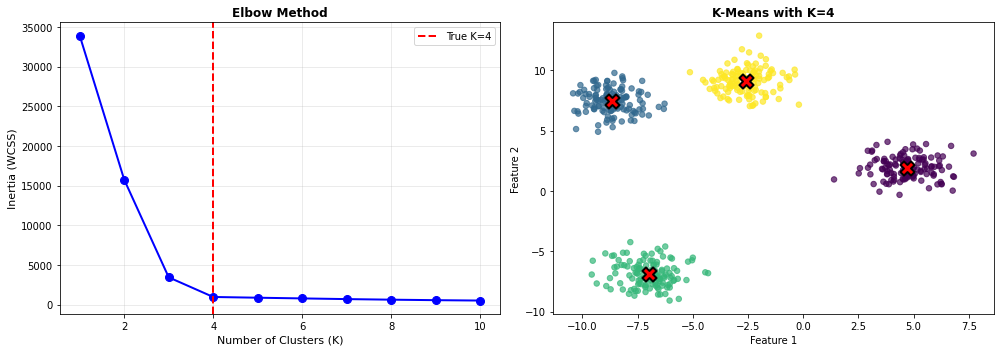

In [15]:
# Elbow method demonstration
np.random.seed(42)
X, _ = make_blobs(n_samples=500, centers=4, cluster_std=1.0, random_state=42)

# Compute inertia for different K values
K_range = range(1, 11)
inertias = []

for K in K_range:
    km = KMeans(n_clusters=K, random_state=42, n_init=10).fit(X)
    inertias.append(km.inertia_)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
ax.axvline(x=4, color='red', linestyle='--', linewidth=2, label='True K=4')
ax.set_xlabel('Number of Clusters (K)', fontsize=11)
ax.set_ylabel('Inertia (WCSS)', fontsize=11)
ax.set_title('Elbow Method', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Show the data
ax = axes[1]
km_best = KMeans(n_clusters=4, random_state=42, n_init=10).fit(X)
ax.scatter(X[:, 0], X[:, 1], c=km_best.labels_, cmap='viridis', s=30, alpha=0.7)
ax.scatter(km_best.cluster_centers_[:, 0], km_best.cluster_centers_[:, 1],
           c='red', marker='X', s=200, edgecolors='black', linewidths=2)
ax.set_title('K-Means with K=4', fontsize=12, fontweight='bold')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

## Silhouette Score: Measuring Cluster Quality

The **Silhouette Score** (Rousseeuw, 1987) is a metric that evaluates clustering quality by measuring how well each point fits within its assigned cluster compared to other clusters.

Unlike the Elbow method (which only measures compactness), the Silhouette Score captures both:
- **Cohesion**: How close points are to others in the same cluster
- **Separation**: How far points are from the nearest different cluster

### Mathematical Definition

For each point $\mathbf{x}_i$ assigned to cluster $C_k$, we compute:

**1. Intra-cluster distance (cohesion):**

$$a(i) = \frac{1}{|C_k| - 1} \sum_{\mathbf{x}_j \in C_k, j \neq i} d(\mathbf{x}_i, \mathbf{x}_j)$$

This is the average distance from $\mathbf{x}_i$ to all other points in its own cluster. **Lower is better** — it means the point is close to its cluster mates.

**2. Nearest-cluster distance (separation):**

$$b(i) = \min_{C_l \neq C_k} \frac{1}{|C_l|} \sum_{\mathbf{x}_j \in C_l} d(\mathbf{x}_i, \mathbf{x}_j)$$

This is the average distance from $\mathbf{x}_i$ to points in the *nearest other cluster*. **Higher is better** — it means the point is far from other clusters.

**3. Silhouette coefficient for point $i$:**

$$s(i) = \frac{b(i) - a(i)}{\max\{a(i), b(i)\}}$$

<div style="background-color: #e3f2fd; padding: 15px; border-left: 5px solid #2196F3; margin: 20px 0;">
<strong>💡 Intuition</strong><br>
Think of it this way:
<ul>
<li><strong>a(i)</strong> measures "How well do I fit with my assigned group?"</li>
<li><strong>b(i)</strong> measures "How different am I from the closest other group?"</li>
<li><strong>s(i)</strong> combines both: "Am I in the right group?"</li>
</ul>
A good clustering maximizes the difference between b(i) and a(i).
</div>

A **silhouette plot** visualizes the silhouette coefficient for every point, grouped by cluster. This provides rich information:

- **Width** of each cluster's silhouette shows cluster size
- **Shape** reveals consistency — ideally uniform and wide
- **Negative values** indicate potentially misclassified points
- **Red dashed line** shows the overall average

Estimated number of clusters: 4
Estimated number of noise points: 27


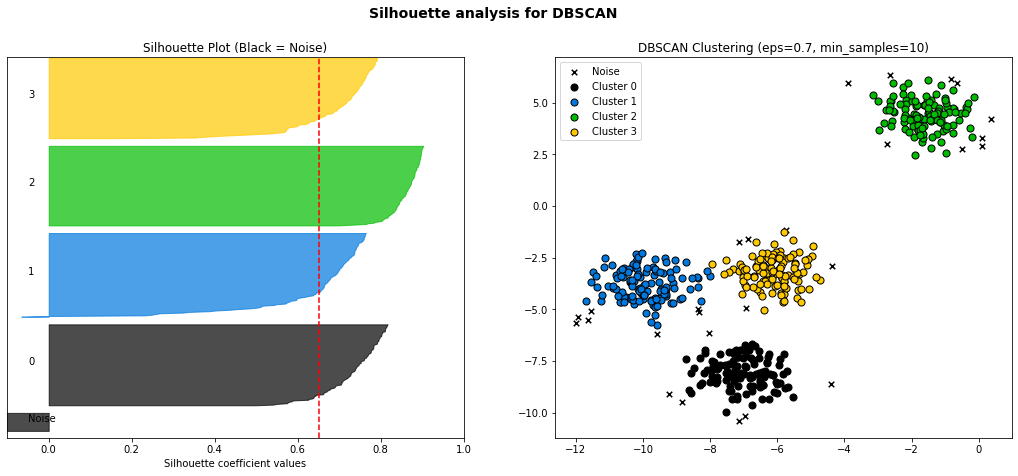

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score

# Generate sample data
X, y = make_blobs(n_samples=500, n_features=2, centers=4, cluster_std=0.8, random_state=1)

# Run DBSCAN
# Note: eps and min_samples must be tuned to your specific data scale
db = DBSCAN(eps=0.7, min_samples=10).fit(X)
cluster_labels = db.labels_
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = list(cluster_labels).count(-1)

print(f"Estimated number of clusters: {n_clusters}")
print(f"Estimated number of noise points: {n_noise}")

# Check if clustering is valid for silhouette (needs at least 2 clusters or 1 cluster + noise)
if n_clusters > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # --- Plot 1: Silhouette Plot ---
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    silhouette_avg = silhouette_score(X, cluster_labels)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    # Get unique labels (sorted, ensuring -1 is first if present)
    unique_labels = sorted(set(cluster_labels))

    for i in unique_labels:
        # Aggregate scores
        ith_cluster_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_values.sort()
        size_cluster_i = ith_cluster_values.shape[0]
        y_upper = y_lower + size_cluster_i

        # Color logic: Black for noise (-1), Spectral for clusters
        if i == -1:
            color = "black"
            label_text = "Noise"
        else:
            color = cm.nipy_spectral(float(i) / n_clusters)
            label_text = str(i)

        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, label_text)
        y_lower = y_upper + 10

    ax1.set_title("Silhouette Plot (Black = Noise)")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])

    # --- Plot 2: DBSCAN Visualization ---
    # Plot Noise first
    noise_mask = (cluster_labels == -1)
    ax2.scatter(X[noise_mask, 0], X[noise_mask, 1], c="black", marker='x', s=30, label="Noise")

    # Plot Clusters
    for i in range(n_clusters):
        cluster_mask = (cluster_labels == i)
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax2.scatter(X[cluster_mask, 0], X[cluster_mask, 1], s=50, c=[color], 
                    edgecolor='k', label=f"Cluster {i}")

    ax2.set_title(f"DBSCAN Clustering (eps=0.7, min_samples=10)")
    ax2.legend()

    plt.suptitle(f"Silhouette analysis for DBSCAN", fontsize=14, fontweight='bold')
    plt.show()

else:
    print("Error: DBSCAN found less than 2 distinct labels (including noise). Adjust eps/min_samples.")

| Strengths | Limitations |
|-----------|-------------|
| Works for any clustering algorithm | Assumes convex clusters (like K-Means) |
| Bounded range [-1, +1] is easy to interpret | Computationally expensive: O(n²) |
| Captures both cohesion and separation | May not work well for density-based clusters |
| Per-point analysis reveals problematic assignments | Sensitive to cluster shape |
| No need for ground truth labels | |

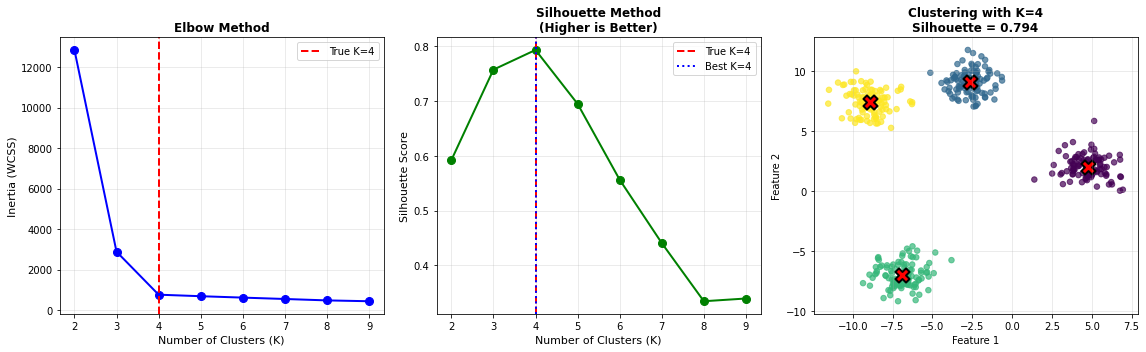


Silhouette Scores by K:
  K=2: 0.592
  K=3: 0.758
  K=4: 0.794 <-- Best
  K=5: 0.695
  K=6: 0.556
  K=7: 0.440
  K=8: 0.334
  K=9: 0.339


In [17]:
# Compare Elbow Method and Silhouette Score for choosing K
from sklearn.metrics import silhouette_score

# Generate data with clear structure
np.random.seed(42)
X_test, _ = make_blobs(n_samples=400, centers=4, cluster_std=1.0, random_state=42)

K_range = range(2, 10)
inertias = []
silhouette_scores = []

for K in K_range:
    km = KMeans(n_clusters=K, random_state=42, n_init=10)
    km.fit(X_test)
    
    inertias.append(km.inertia_)
    silhouette_scores.append(silhouette_score(X_test, km.labels_))

# Find best K according to silhouette
best_k_sil = K_range[np.argmax(silhouette_scores)]

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Elbow plot
ax = axes[0]
ax.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
ax.axvline(x=4, color='red', linestyle='--', linewidth=2, label='True K=4')
ax.set_xlabel('Number of Clusters (K)', fontsize=11)
ax.set_ylabel('Inertia (WCSS)', fontsize=11)
ax.set_title('Elbow Method', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Silhouette score plot
ax = axes[1]
ax.plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
ax.axvline(x=4, color='red', linestyle='--', linewidth=2, label='True K=4')
ax.axvline(x=best_k_sil, color='blue', linestyle=':', linewidth=2, label=f'Best K={best_k_sil}')
ax.set_xlabel('Number of Clusters (K)', fontsize=11)
ax.set_ylabel('Silhouette Score', fontsize=11)
ax.set_title('Silhouette Method\n(Higher is Better)', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Show the data
ax = axes[2]
km_best = KMeans(n_clusters=4, random_state=42, n_init=10).fit(X_test)
ax.scatter(X_test[:, 0], X_test[:, 1], c=km_best.labels_, cmap='viridis', s=30, alpha=0.7)
ax.scatter(km_best.cluster_centers_[:, 0], km_best.cluster_centers_[:, 1],
           c='red', marker='X', s=200, edgecolors='black', linewidths=2)
ax.set_title(f'Clustering with K=4\nSilhouette = {silhouette_scores[2]:.3f}', 
             fontsize=12, fontweight='bold')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nSilhouette Scores by K:")
for k, score in zip(K_range, silhouette_scores):
    marker = " <-- Best" if k == best_k_sil else ""
    print(f"  K={k}: {score:.3f}{marker}")

Best Parameters:
 eps: 0.10
 min_samples: 11
 score: 0.808


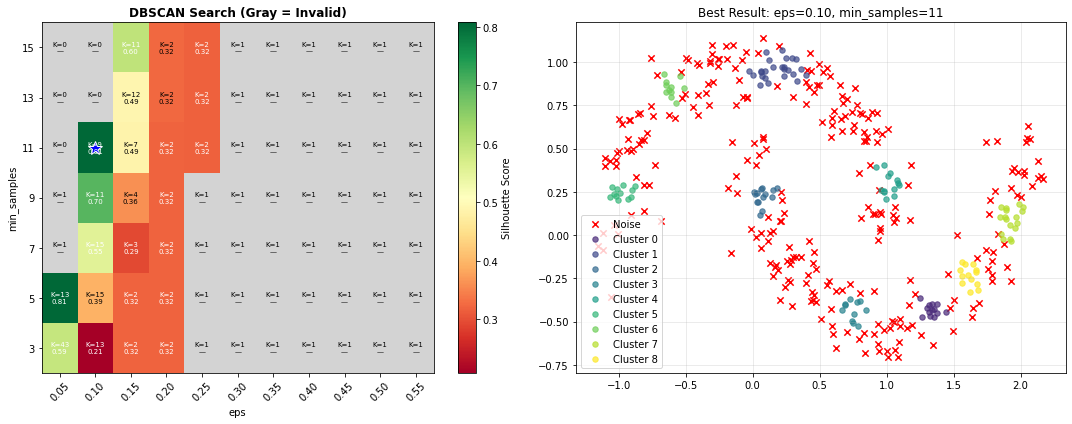

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_moons

# 1. Generate Data
np.random.seed(42)
X, _ = make_moons(n_samples=400, noise=0.1, random_state=42)

# 2. Define Parameters
eps_values = np.arange(0.05, 0.60, 0.05)
min_samples_values = [3, 5, 7, 9, 11, 13, 15]

n_eps = len(eps_values)
n_min_samples = len(min_samples_values)

# 3. Grid Search
silhouette_matrix = np.full((n_min_samples, n_eps), np.nan)
n_clusters_matrix = np.zeros((n_min_samples, n_eps), dtype=int)

for i, min_samples in enumerate(min_samples_values):
    for j, eps in enumerate(eps_values):
        
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(X)
        
        # Calculate number of clusters (excluding noise -1)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_clusters_matrix[i, j] = n_clusters
        
        # Calculate Silhouette only if valid (>= 2 clusters, not empty)
        non_noise = labels != -1
        if n_clusters >= 2 and non_noise.sum() > 1:
            sil = silhouette_score(X[non_noise], labels[non_noise])
            silhouette_matrix[i, j] = sil

# 4. Find Best Parameters
# Using nanargmax to ignore NaNs (failed clusterings)
if np.isnan(silhouette_matrix).all():
    print("No valid clustering found within parameter range.")
else:
    best_idx = np.unravel_index(np.nanargmax(silhouette_matrix), silhouette_matrix.shape)
    best_min_samples = min_samples_values[best_idx[0]]
    best_eps = eps_values[best_idx[1]]
    best_score = silhouette_matrix[best_idx]

    print("Best Parameters:")
    print(f" eps: {best_eps:.2f}")
    print(f" min_samples: {best_min_samples}")
    print(f" score: {best_score:.3f}")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# --- Heatmap ---
ax = axes[0]
ax.set_facecolor('lightgray') # Gray background for NaNs

# Mask NaNs so they show the gray background
masked_matrix = np.ma.masked_where(np.isnan(silhouette_matrix), silhouette_matrix)

# Dynamic scaling (no vmin/vmax) ensures distinct colors
im = ax.imshow(masked_matrix, cmap='RdYlGn', aspect='auto', origin='lower')
plt.colorbar(im, ax=ax, label='Silhouette Score')

ax.set_xticks(range(n_eps))
ax.set_xticklabels([f'{e:.2f}' for e in eps_values], rotation=45)
ax.set_yticks(range(n_min_samples))
ax.set_yticklabels(min_samples_values)
ax.set_xlabel('eps')
ax.set_ylabel('min_samples')
ax.set_title('DBSCAN Search (Gray = Invalid)', fontweight='bold')

# Annotate cells
for i in range(n_min_samples):
    for j in range(n_eps):
        k = n_clusters_matrix[i, j]
        s = silhouette_matrix[i, j]
        
        txt = f'K={k}\n{s:.2f}' if not np.isnan(s) else f'K={k}\n—'
        # Contrast text color
        text_color = 'white' if not np.isnan(s) and abs(s - np.nanmean(silhouette_matrix)) > 0.1 else 'black'
        ax.text(j, i, txt, ha='center', va='center', fontsize=7, color=text_color)

# Highlight best
if not np.isnan(silhouette_matrix).all():
    ax.plot(best_idx[1], best_idx[0], 'b*', markersize=15, markeredgecolor='white')

ax = axes[1]
if not np.isnan(silhouette_matrix).all():
    db_best = DBSCAN(eps=best_eps, min_samples=best_min_samples)
    labels_best = db_best.fit_predict(X)
    
    unique_labels = set(labels_best)
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))
    
    for k, col in zip(sorted(unique_labels), colors):
        mask = labels_best == k
        if k == -1:
            ax.scatter(X[mask, 0], X[mask, 1], c='red', marker='x', s=40, label='Noise')
        else:
            ax.scatter(X[mask, 0], X[mask, 1], c=[col], s=30, alpha=0.7, label=f'Cluster {k}')
            
    ax.set_title(f'Best Result: eps={best_eps:.2f}, min_samples={best_min_samples}')
else:
    ax.text(0.5, 0.5, "No valid clusters found", ha='center')

ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Information Criteria (GMM)

For probabilistic models like GMM, we can use information criteria that balance fit quality against model complexity.

**Akaike Information Criterion (AIC):**
$$\text{AIC} = -2 \log L + 2p$$

**Bayesian Information Criterion (BIC):**
$$\text{BIC} = -2 \log L + p \log n$$

where:
- $L$ is the likelihood of the data given the model
- $p$ is the number of parameters
- $n$ is the number of observations

**Lower values are better.** BIC penalizes complexity more strongly than AIC, especially for large $n$.

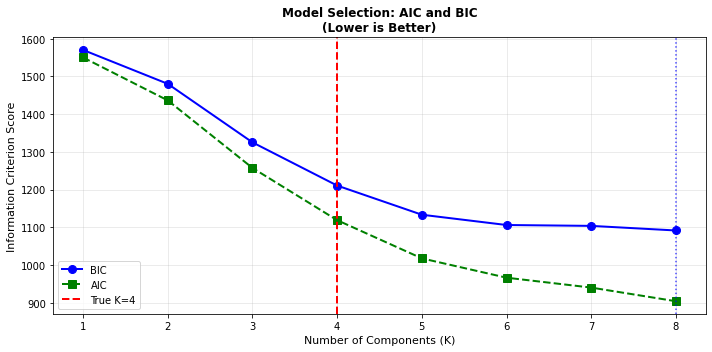

Best K according to BIC: 8
Best K according to AIC: 8


In [19]:
# BIC/AIC for GMM
K_range = range(1, 9)
bic_scores = []
aic_scores = []

for K in K_range:
    gmm = GaussianMixture(n_components=K, random_state=42, n_init=5).fit(X)
    bic_scores.append(gmm.bic(X))
    aic_scores.append(gmm.aic(X))

# Plot
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(K_range, bic_scores, 'bo-', linewidth=2, markersize=8, label='BIC')
ax.plot(K_range, aic_scores, 'gs--', linewidth=2, markersize=8, label='AIC')

# Mark minimum
best_k_bic = K_range[np.argmin(bic_scores)]
best_k_aic = K_range[np.argmin(aic_scores)]
ax.axvline(x=best_k_bic, color='blue', linestyle=':', alpha=0.7)
ax.axvline(x=4, color='red', linestyle='--', linewidth=2, label='True K=4')

ax.set_xlabel('Number of Components (K)', fontsize=11)
ax.set_ylabel('Information Criterion Score', fontsize=11)
ax.set_title('Model Selection: AIC and BIC\n(Lower is Better)', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Best K according to BIC: {best_k_bic}")
print(f"Best K according to AIC: {best_k_aic}")

**Log-Likelihood**

We can also directly examine the log-likelihood, but it always increases with more components (overfitting). That's why we need the complexity penalty from AIC/BIC.

---

# Python Laboratory

---

## Laboratory Exercises

### Step 1: Generate Synthetic Data

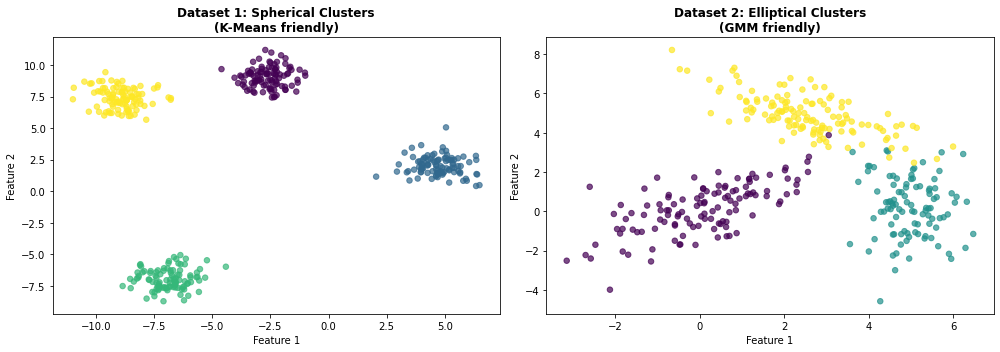

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

np.random.seed(42)

# Dataset 1: Spherical clusters with equal variance (good for K-Means)
X_spherical, y_spherical = make_blobs(n_samples=400, centers=4, 
                                       cluster_std=0.8, random_state=42)

# Dataset 2: Elliptical clusters with different variances (better for GMM)
X1 = np.random.multivariate_normal([0, 0], [[2, 1.5], [1.5, 2]], 120)
X2 = np.random.multivariate_normal([5, 0], [[0.5, 0], [0, 2]], 100)
X3 = np.random.multivariate_normal([2.5, 5], [[1.5, -0.8], [-0.8, 1]], 130)
X_elliptical = np.vstack([X1, X2, X3])
y_elliptical = np.array([0]*120 + [1]*100 + [2]*130)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(X_spherical[:, 0], X_spherical[:, 1], c=y_spherical, 
                cmap='viridis', s=30, alpha=0.7)
axes[0].set_title('Dataset 1: Spherical Clusters\n(K-Means friendly)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')

axes[1].scatter(X_elliptical[:, 0], X_elliptical[:, 1], c=y_elliptical, 
                cmap='viridis', s=30, alpha=0.7)
axes[1].set_title('Dataset 2: Elliptical Clusters\n(GMM friendly)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

### Step 2: K-Means Analysis

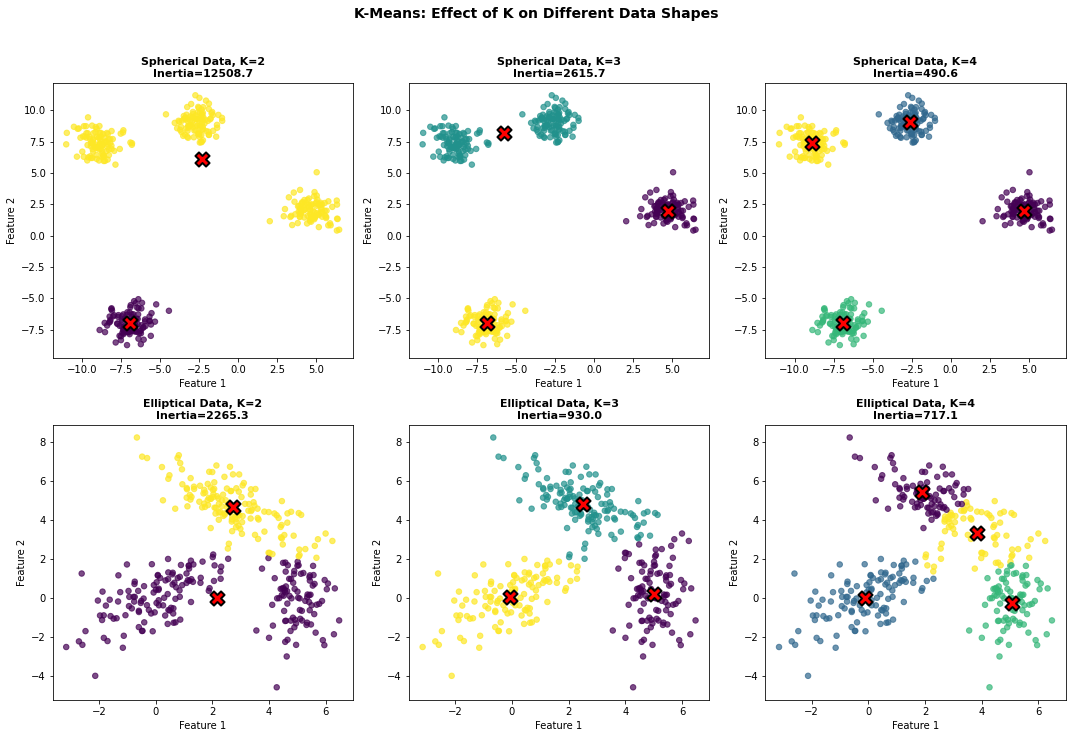

In [21]:
# K-Means on both datasets
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

datasets = [(X_spherical, 'Spherical'), (X_elliptical, 'Elliptical')]

for row, (X, name) in enumerate(datasets):
    for col, K in enumerate([2, 3, 4]):
        km = KMeans(n_clusters=K, random_state=42, n_init=10).fit(X)
        
        ax = axes[row, col]
        ax.scatter(X[:, 0], X[:, 1], c=km.labels_, cmap='viridis', s=30, alpha=0.7)
        ax.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
                   c='red', marker='X', s=200, edgecolors='black', linewidths=2)
        ax.set_title(f'{name} Data, K={K}\nInertia={km.inertia_:.1f}', 
                     fontsize=11, fontweight='bold')
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')

plt.suptitle('K-Means: Effect of K on Different Data Shapes', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### Step 3: Effect of Initialization

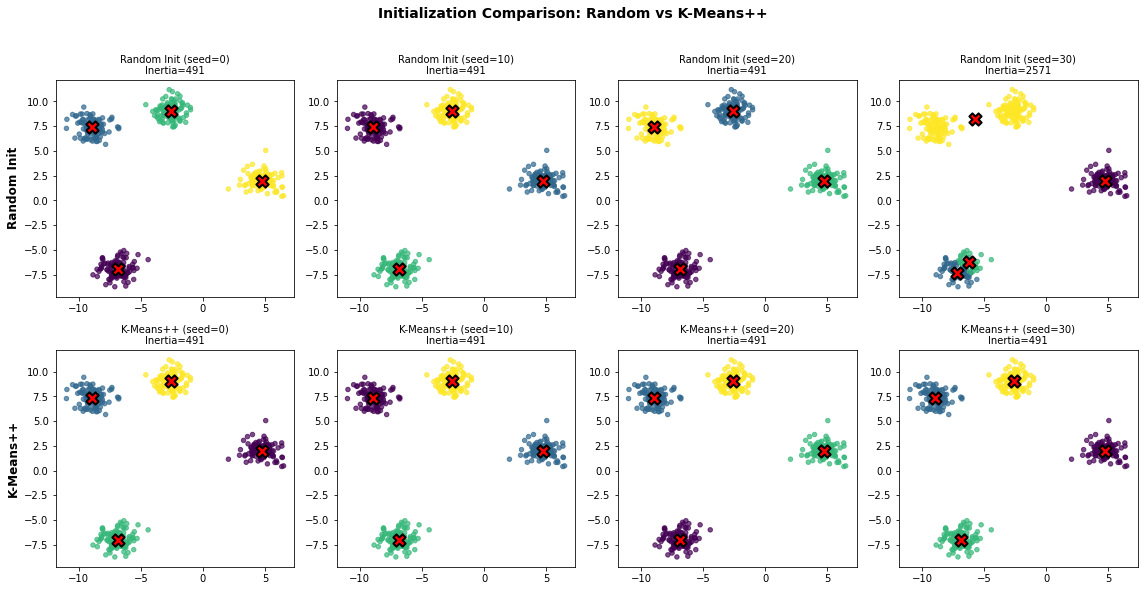

In [22]:
# Compare random init vs K-Means++
X = X_spherical

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Random initialization
for i in range(4):
    km = KMeans(n_clusters=4, init='random', n_init=1, random_state=i*10).fit(X)
    axes[0, i].scatter(X[:, 0], X[:, 1], c=km.labels_, cmap='viridis', s=20, alpha=0.7)
    axes[0, i].scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
                       c='red', marker='X', s=150, edgecolors='black', linewidths=2)
    axes[0, i].set_title(f'Random Init (seed={i*10})\nInertia={km.inertia_:.0f}', fontsize=10)

# K-Means++ initialization
for i in range(4):
    km = KMeans(n_clusters=4, init='k-means++', n_init=5, random_state=i*10).fit(X)
    axes[1, i].scatter(X[:, 0], X[:, 1], c=km.labels_, cmap='viridis', s=20, alpha=0.7)
    axes[1, i].scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
                       c='red', marker='X', s=150, edgecolors='black', linewidths=2)
    axes[1, i].set_title(f'K-Means++ (seed={i*10})\nInertia={km.inertia_:.0f}', fontsize=10)

axes[0, 0].set_ylabel('Random Init', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('K-Means++', fontsize=12, fontweight='bold')

plt.suptitle('Initialization Comparison: Random vs K-Means++', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### Step 4: Gaussian Mixture Models

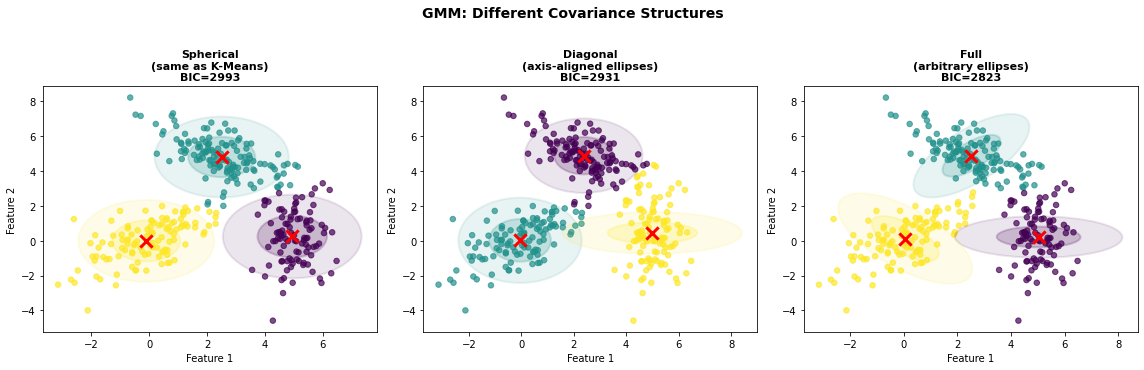

In [23]:
# GMM with different covariance types
X = X_elliptical

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

cov_types = ['spherical', 'diag', 'full']
titles = ['Spherical\n(same as K-Means)', 'Diagonal\n(axis-aligned ellipses)', 'Full\n(arbitrary ellipses)']

for ax, cov_type, title in zip(axes, cov_types, titles):
    gmm = GaussianMixture(n_components=3, covariance_type=cov_type, 
                          random_state=42, n_init=5).fit(X)
    
    labels = gmm.predict(X)
    ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=30, alpha=0.7)
    
    # Draw ellipses for 'full' covariance
    colors = plt.cm.viridis(np.linspace(0, 1, 3))
    for k in range(3):
        if cov_type == 'full':
            cov = gmm.covariances_[k]
        elif cov_type == 'diag':
            cov = np.diag(gmm.covariances_[k])
        else:  # spherical
            cov = gmm.covariances_[k] * np.eye(2)
        draw_ellipse(ax, gmm.means_[k], cov, colors[k], alpha=0.2)
        ax.scatter(*gmm.means_[k], c='red', marker='x', s=150, linewidths=3)
    
    ax.set_title(f'{title}\nBIC={gmm.bic(X):.0f}', fontsize=11, fontweight='bold')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')

plt.suptitle('GMM: Different Covariance Structures', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### Step 5: Analyzing Responsibilities

Number of ambiguous points (max P < 0.7): 9 out of 350


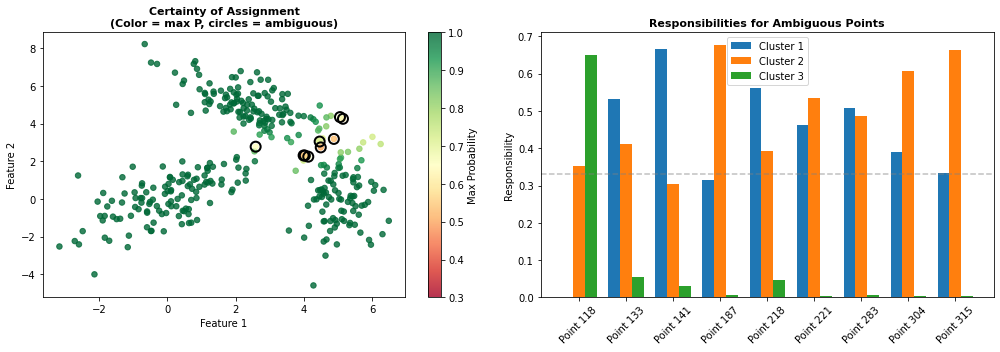

In [24]:
# Examine soft assignments
gmm = GaussianMixture(n_components=3, covariance_type='full', 
                      random_state=42, n_init=5).fit(X_elliptical)

responsibilities = gmm.predict_proba(X_elliptical)

# Find ambiguous points (max probability < 0.7)
max_prob = responsibilities.max(axis=1)
ambiguous_mask = max_prob < 0.7

print(f"Number of ambiguous points (max P < 0.7): {ambiguous_mask.sum()} out of {len(X_elliptical)}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Color by max probability (uncertainty)
ax = axes[0]
scatter = ax.scatter(X_elliptical[:, 0], X_elliptical[:, 1], c=max_prob, 
                     cmap='RdYlGn', s=30, alpha=0.8, vmin=0.3, vmax=1.0)
ax.scatter(X_elliptical[ambiguous_mask, 0], X_elliptical[ambiguous_mask, 1], 
           facecolors='none', edgecolors='black', s=100, linewidths=2)
ax.set_title('Certainty of Assignment\n(Color = max P, circles = ambiguous)', fontsize=11, fontweight='bold')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
plt.colorbar(scatter, ax=ax, label='Max Probability')

# Show responsibilities for ambiguous points
ax = axes[1]
if ambiguous_mask.sum() > 0:
    ambig_idx = np.where(ambiguous_mask)[0][:10]  # First 10 ambiguous
    resp_ambig = responsibilities[ambig_idx]
    
    x_pos = np.arange(len(ambig_idx))
    width = 0.25
    
    for k in range(3):
        ax.bar(x_pos + k*width, resp_ambig[:, k], width, label=f'Cluster {k+1}')
    
    ax.set_xticks(x_pos + width)
    ax.set_xticklabels([f'Point {i}' for i in ambig_idx], rotation=45)
    ax.set_ylabel('Responsibility')
    ax.set_title('Responsibilities for Ambiguous Points', fontsize=11, fontweight='bold')
    ax.legend()
    ax.axhline(0.33, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### Step 6: Model Selection (Elbow + BIC Comparison)

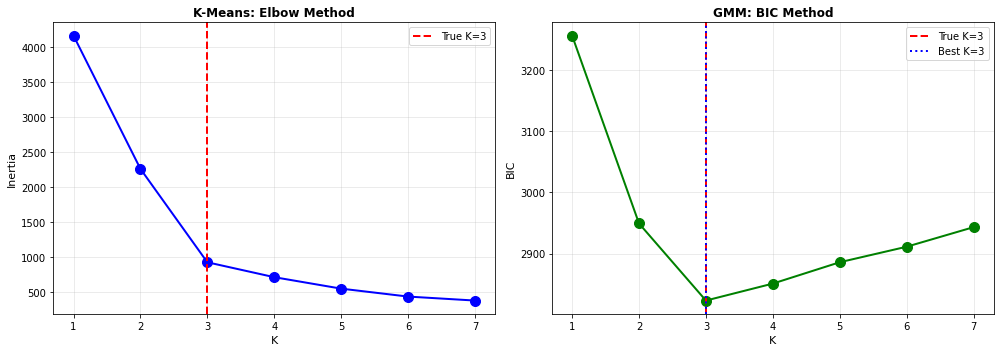

In [25]:
# Compare K-Means inertia and GMM BIC
X = X_elliptical
K_range = range(1, 8)

inertias = []
bic_scores = []

for K in K_range:
    km = KMeans(n_clusters=K, random_state=42, n_init=10).fit(X)
    inertias.append(km.inertia_)
    
    gmm = GaussianMixture(n_components=K, random_state=42, n_init=5).fit(X)
    bic_scores.append(gmm.bic(X))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow for K-Means
ax = axes[0]
ax.plot(K_range, inertias, 'bo-', linewidth=2, markersize=10)
ax.axvline(x=3, color='red', linestyle='--', linewidth=2, label='True K=3')
ax.set_xlabel('K', fontsize=11)
ax.set_ylabel('Inertia', fontsize=11)
ax.set_title('K-Means: Elbow Method', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# BIC for GMM
ax = axes[1]
ax.plot(K_range, bic_scores, 'go-', linewidth=2, markersize=10)
ax.axvline(x=3, color='red', linestyle='--', linewidth=2, label='True K=3')
best_k = K_range[np.argmin(bic_scores)]
ax.axvline(x=best_k, color='blue', linestyle=':', linewidth=2, label=f'Best K={best_k}')
ax.set_xlabel('K', fontsize=11)
ax.set_ylabel('BIC', fontsize=11)
ax.set_title('GMM: BIC Method', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

#  FAQ

---


### When is K-Means a bad idea?

K-Means performs poorly when:
- Clusters have very different sizes or densities
- Clusters are elongated (non-spherical)
- Data contains outliers
- Cluster boundaries are not linear

### Is GMM really "clustering" or "density estimation"?

This is a subtle but important distinction. GMM is fundamentally a **density estimation** method — it models the probability distribution of the data. Clustering is a *byproduct*: we assign points to the component with highest responsibility.

This means GMM can be used for:
- Generating new synthetic data
- Computing likelihood of new observations
- Anomaly detection (points with low overall probability)

### What happens in high dimensions?

Both methods struggle in high dimensions:
- **K-Means**: Distances concentrate (curse of dimensionality), making separation harder
- **GMM**: Covariance estimation becomes unstable (more parameters than observations)

Solutions include:
- Dimensionality reduction before clustering (PCA, t-SNE, UMAP)
- Using diagonal or spherical covariance in GMM
- Regularization


### Why choose HDBSCAN over DBSCAN?


- **DBSCAN**: Requires a constant density (single eps). It fails if one cluster is tight (high density) and another is spread out (low density).

- **HDBSCAN**: Is hierarchical. It adapts to varying densities, finding clusters that persist over different density thresholds. It also removes the need to guess the difficult eps parameter.


### Can I predict clusters for new data points? (Inductive vs. Transductive)

- **K-Means & GMM**: Yes (Inductive). You can save the model and call $<em>.predict(new_data)<\em>$ easily because they are based on fixed centroids/distributions.

- **DBSCAN & HDBSCAN**: Mostly No (Transductive). They define clusters based on the specific connections in the training set. Classifying a new point often requires computationally expensive approximations or re-running the algorithm (though approximate_predict exists in some HDBSCAN implementations, it's not native/simple like K-Means).

## A last comparison table

| Aspect | K-Means | DBSCAN | GMM |
|--------|---------|--------|-----|
| **Paradigm** | Distance to centroids | Density connectivity | Probabilistic mixture |
| **Cluster shape** | Spherical | Arbitrary | Elliptical |
| **# Clusters** | Must specify K | Discovered automatically | Must specify K |
| **Assignment** | Hard | Hard + Noise | Soft (probabilities) |
| **Outliers** | Forced into clusters | Identified as noise | Low probability |
| **Parameters** | K | ε, MinPts | K, covariance type |
| **Speed** | Fast | Fast with indexing | Slower |
| **Scalability** | Excellent | Good | Moderate |

---

# Assignments

---

## Exercise 1: DBSCAN vs K-Means

**Using the provided dataset:**

1. Apply DBSCAN with `eps=0.5` and `min_samples=5`
2. Apply K-Means with K equal to the number of clusters found by DBSCAN (excluding noise)
3. Compare: How many points does DBSCAN label as noise? How does K-Means handle these?
4. Visualize both results side by side (use a distinct color for DBSCAN noise points)
5. Comment on which method seems more appropriate for this data structure and why

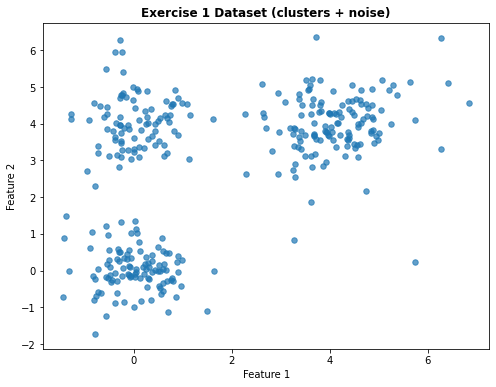

In [26]:
# Dataset for Exercise 1 - clusters with noise and outliers
np.random.seed(2024)

# Three dense clusters
ex1_X1 = np.random.multivariate_normal([0, 0], [[0.3, 0], [0, 0.3]], 100)
ex1_X2 = np.random.multivariate_normal([4, 4], [[0.4, 0.1], [0.1, 0.4]], 120)
ex1_X3 = np.random.multivariate_normal([0, 4], [[0.3, 0], [0, 0.3]], 80)

# Add scattered noise points
ex1_noise = np.random.uniform(low=-2, high=7, size=(30, 2))

ex1_X = np.vstack([ex1_X1, ex1_X2, ex1_X3, ex1_noise])

plt.figure(figsize=(8, 6))
plt.scatter(ex1_X[:, 0], ex1_X[:, 1], s=30, alpha=0.7)
plt.title('Exercise 1 Dataset (clusters + noise)', fontsize=12, fontweight='bold')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# YOUR CODE HERE
# 1. Apply DBSCAN (eps=0.5, min_samples=5)
# 2. Count clusters and noise points
# 3. Apply K-Means with K = number of DBSCAN clusters
# 4. Visualize side by side
# 5. Comment on the differences

pass

## Exercise 2: Non-Globular Cluster Shapes

**Using the dataset below (which contains non-convex clusters):**

1. Apply K-Means with K=2
2. Apply DBSCAN with appropriate parameters (you may need to experiment)
3. Visualize both results side by side
4. Compute the Adjusted Rand Index (ARI) for both methods against the true labels
5. Discuss: Why does one method outperform the other on this data? What does this reveal about the assumptions underlying each algorithm?

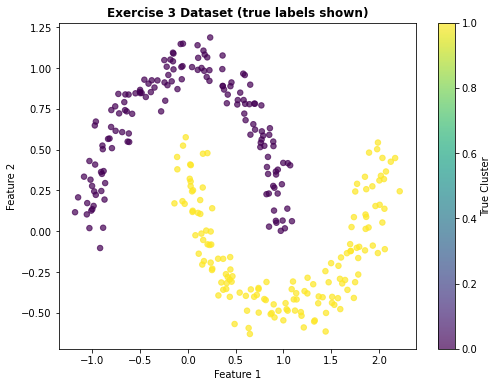

In [27]:
# Dataset for Exercise 3 - non-convex clusters (moons)
from sklearn.datasets import make_moons
from sklearn.metrics import adjusted_rand_score

np.random.seed(42)
ex2_X, ex2_true_labels = make_moons(n_samples=300, noise=0.08, random_state=42)

plt.figure(figsize=(8, 6))
plt.scatter(ex2_X[:, 0], ex2_X[:, 1], c=ex2_true_labels, cmap='viridis', s=30, alpha=0.7)
plt.title('Exercise 3 Dataset (true labels shown)', fontsize=12, fontweight='bold')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='True Cluster')
plt.show()

# YOUR CODE HERE
# 1. Apply K-Means (K=2)
# 2. Apply DBSCAN (tune eps and min_samples)
# 3. Visualize both
# 4. Compute ARI for both
# 5. Write interpretation

pass

*Write your interpretation here:*

...

## Exercise 3: Core, Border, and Noise Points

**Using DBSCAN on the dataset from Exercise 1:**

1. Fit DBSCAN with `eps=0.5` and `min_samples=5`
2. Identify and separately visualize: core points, border points, and noise points
3. For 3 randomly selected core points, visualize their eps-neighborhoods
4. Discuss: What is the role of each point type in DBSCAN's cluster formation process? Why might border points be considered "ambiguous"?

In [28]:
# Use ex1_X from Exercise 1

# YOUR CODE HERE
# 1. Fit DBSCAN
# 2. Identify core points (use .core_sample_indices_)
# 3. Identify border points (in a cluster but not core)
# 4. Identify noise points (label == -1)
# 5. Visualize with different markers/colors
# 6. Draw eps-neighborhoods for selected core points
# 7. Write interpretation

pass

*Write your interpretation here:*

...

## Exercise 4: Gaussian Mixture Models Application

**Using the provided dataset:**

1. Apply GMM with K=3 components and `covariance_type='full'`
2. Visualize the clustering results along with the fitted Gaussian ellipses
3. Extract the responsibilities (posterior probabilities) for all points
4. Identify the 10 most "ambiguous" points (those with the lowest maximum responsibility)
5. Create a visualization highlighting these ambiguous points and display their responsibility distributions
6. Use BIC to compare models with K ranging from 2 to 6 — which K is optimal?
7. Discussion: What does "ambiguity" mean in the context of GMM? Is high ambiguity a problem or useful information?

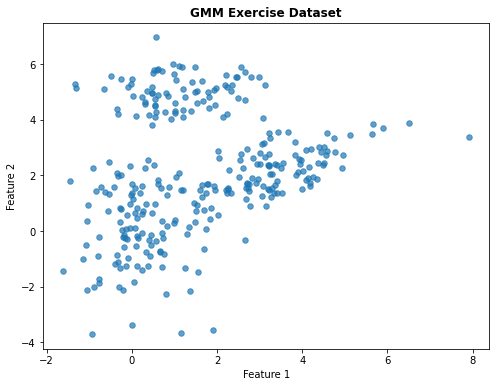

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse

# Dataset generation
np.random.seed(2024)

# Three clusters with different shapes and orientations
X1 = np.random.multivariate_normal([0, 0], [[0.5, 0], [0, 2]], 100)
X2 = np.random.multivariate_normal([3, 2], [[1.5, 0.8], [0.8, 0.8]], 120)
X3 = np.random.multivariate_normal([1, 5], [[1, 0], [0, 0.3]], 80)
X = np.vstack([X1, X2, X3])

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], s=30, alpha=0.7)
plt.title('GMM Exercise Dataset', fontsize=12, fontweight='bold')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# YOUR CODE HERE
# 1. Fit GMM with K=3 and covariance_type='full'
# 2. Visualize clusters and Gaussian ellipses
# 3. Extract responsibilities using predict_proba()
# 4. Find the 10 most ambiguous points
# 5. Visualize ambiguous points and their responsibility distributions
# 6. Compare BIC for K=2 to K=6
# 7. Write interpretation

pass

---

# References

1. **Bishop, C. M.** (2006). *Pattern Recognition and Machine Learning*. Springer. **Chapter 9: Mixture Models and EM**

2. **Murphy, K. P.** (2012). *Machine Learning: A Probabilistic Perspective*. MIT Press. **Chapters 11 and 25**

3. **Hastie, T., Tibshirani, R., & Friedman, J.** (2009). *The Elements of Statistical Learning* (2nd ed.). Springer. **Chapter 14: Unsupervised Learning**

---

# Bonus Algorithm(1)! $\rightarrow$ Hierarhical Clustering

Hierarchical clustering builds a tree of clusters (dendrogram). 

Two approaches:

- **Agglomerative (bottom-up)**: Merge closest clusters iteratively.
- **Divisive (top-down)**: Split clusters recursively.

**How?**

- 1.At the start, treat each data point as one cluster. So we will have a number of cluster equal to K
- 2.Form a cluster by joining the two closest data points resulting in K-1 clusters.
- 3.Form more clusters by joining the two closest clusters resulting in K-2 clusters.
- 4.Repeat the above three steps until one big cluster is formed 

When you applied agglomerative algorithm you should chose which **linkage criterion** to use

The linkage criterion determines which distance to use between sets of observation.

The algorithm will merge the pairs of cluster that minimize this criterion.

- **‘ward’** minimizes the variance of the clusters being merged.
- **‘average’** uses the average of the distances of each observation of the two sets.
- **‘complete’** or *‘maximum’* linkage uses the maximum distances between all observations of the two sets.
- **‘single’** uses the minimum of the distances between all observations of the two sets.



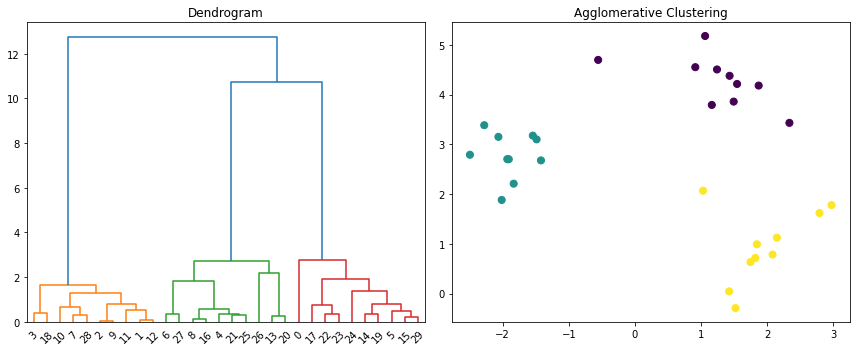

In [30]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Generate data
X, _ = make_blobs(n_samples=30, centers=3, cluster_std=0.60, random_state=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot dendrogram 
linked = linkage(X, method='ward')
dendrogram(linked, ax=ax1)
ax1.set_title("Dendrogram")

# Apply Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels_agg = agg.fit_predict(X)

ax2.scatter(X[:, 0], X[:, 1], c=labels_agg, cmap='viridis', s=50)
ax2.set_title("Agglomerative Clustering")

plt.tight_layout()
plt.show()

# Bonus Theory Part! $\rightarrow$ Clustering at Scale: Computational Complexity and Scalable Algorithms

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR1nzjqKkXCp3mNN1-SLAWyh7Q6lAHXO2qSgg&s" width="85" height="55" /> 

**What happens when we have:**
- 10 million customers instead of 1,000?
- 10,000 features instead of 10?
- Real-time clustering requirements?

This part addresses these challenges by examining:
1. **Computational complexity** of each algorithm
2. **The curse of dimensionality** and its impact on clustering
3. **Scalable alternatives** (Mini-Batch K-Means, BIRCH, approximate methods)
4. **Distributed computing** approaches (Spark MLlib)


In [1]:
# Setup and imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN, Birch
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from warnings import filterwarnings
filterwarnings("ignore")

np.random.seed(42)

# Plotting style
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

Why Complexity Matters

Understanding algorithmic complexity helps us predict:
- **Will this algorithm finish in reasonable time?**
- **How does runtime scale with data size?**
- **Which algorithm should I choose for my use case?**

We analyze complexity in terms of:
- $n$ = number of observations
- $d$ = number of features (dimensionality)
- $K$ = number of clusters
- $t$ = number of iterations until convergence

| Algorithm | Complexity | Memory | Bottleneck |
| :--- | :--- | :--- | :--- |
| **K-Means** | $O(t \cdot n \cdot K \cdot d)$ | $O(n \cdot d)$ | Large $n$ |
| **DBSCAN** | $O(n \cdot \log n)$ to $O(n^2)$ | $O(n \cdot d)$ | High $d$, dense data |
| **GMM** | $O(t \cdot n \cdot K \cdot d^2)$ | $O(K \cdot d^2)$ | High $d$ |

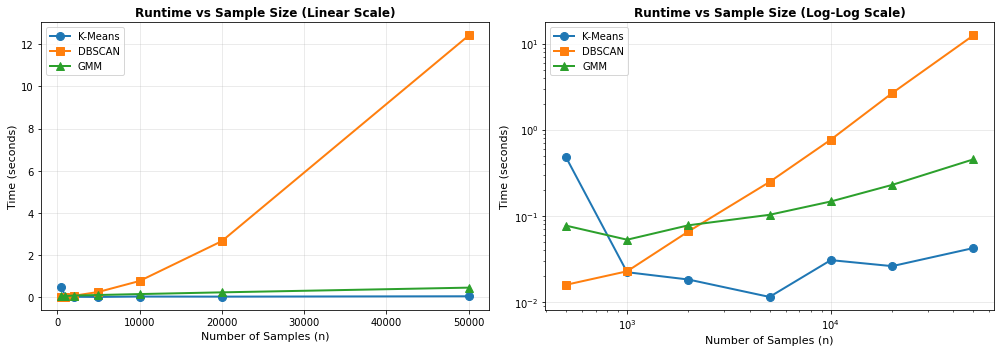


Benchmark Results:
    n   kmeans    dbscan      gmm
  500 0.483969  0.015801 0.077055
 1000 0.022153  0.022710 0.052812
 2000 0.018214  0.065890 0.077639
 5000 0.011440  0.247242 0.102804
10000 0.030600  0.767034 0.146781
20000 0.026055  2.658629 0.228715
50000 0.042198 12.418668 0.452059


In [2]:
# Empirical complexity demonstration

def benchmark_clustering(n_samples_list, n_features=10, n_clusters=5):
    """Benchmark clustering algorithms across different sample sizes."""
    results = {'n': [], 'kmeans': [], 'dbscan': [], 'gmm': []}
    
    for n in n_samples_list:
        X, _ = make_blobs(n_samples=n, n_features=n_features, 
                          centers=n_clusters, random_state=42)
        X = StandardScaler().fit_transform(X)
        
        results['n'].append(n)
        
        # K-Means
        start = time.time()
        KMeans(n_clusters=n_clusters, n_init=1, max_iter=100, random_state=42).fit(X)
        results['kmeans'].append(time.time() - start)
        
        # DBSCAN
        start = time.time()
        DBSCAN(eps=0.5, min_samples=5).fit(X)
        results['dbscan'].append(time.time() - start)
        
        # GMM
        start = time.time()
        GaussianMixture(n_components=n_clusters, max_iter=100, random_state=42).fit(X)
        results['gmm'].append(time.time() - start)
    
    return pd.DataFrame(results)

# Run benchmark
n_samples_list = [500, 1000, 2000, 5000, 10000, 20000, 50000]
bench_n = benchmark_clustering(n_samples_list)

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Linear scale
ax = axes[0]
ax.plot(bench_n['n'], bench_n['kmeans'], 'o-', label='K-Means', linewidth=2, markersize=8)
ax.plot(bench_n['n'], bench_n['dbscan'], 's-', label='DBSCAN', linewidth=2, markersize=8)
ax.plot(bench_n['n'], bench_n['gmm'], '^-', label='GMM', linewidth=2, markersize=8)
ax.set_xlabel('Number of Samples (n)', fontsize=11)
ax.set_ylabel('Time (seconds)', fontsize=11)
ax.set_title('Runtime vs Sample Size (Linear Scale)', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Log-log scale (reveals complexity class)
ax = axes[1]
ax.loglog(bench_n['n'], bench_n['kmeans'], 'o-', label='K-Means', linewidth=2, markersize=8)
ax.loglog(bench_n['n'], bench_n['dbscan'], 's-', label='DBSCAN', linewidth=2, markersize=8)
ax.loglog(bench_n['n'], bench_n['gmm'], '^-', label='GMM', linewidth=2, markersize=8)
ax.set_xlabel('Number of Samples (n)', fontsize=11)
ax.set_ylabel('Time (seconds)', fontsize=11)
ax.set_title('Runtime vs Sample Size (Log-Log Scale)', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nBenchmark Results:")
print(bench_n.to_string(index=False))

In high dimensions, a counterintuitive phenomenon occurs: **all pairwise distances become nearly equal**.

Formally, for random points uniformly distributed in a $d$-dimensional hypercube:

$$\lim_{d \to \infty} \frac{\max_{i,j} \|x_i - x_j\| - \min_{i,j} \|x_i - x_j\|}{\min_{i,j} \|x_i - x_j\|} \to 0$$

This means the **contrast** between nearest and farthest neighbors vanishes.

| Algorithm | Impact |
|-----------|--------|
| K-Means | Distance to centroid becomes meaningless |
| DBSCAN | $\varepsilon$-neighborhoods contain all or no points |
| GMM | Covariance estimation becomes unstable |

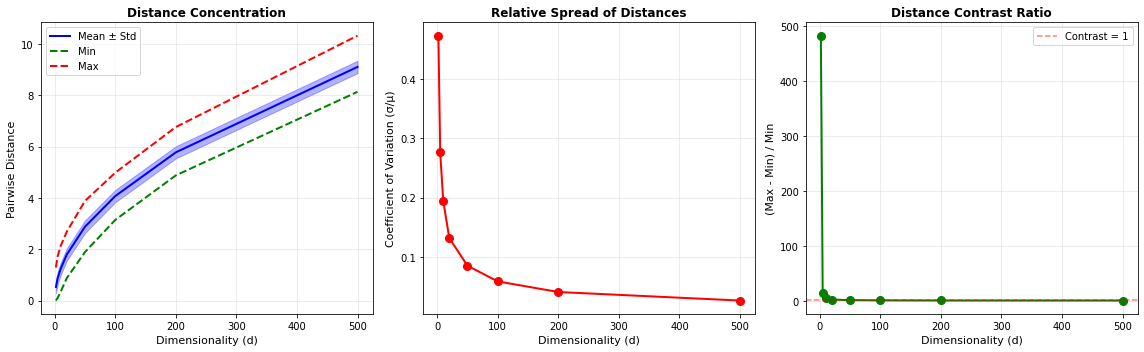


⚠️ Curse of Dimensionality Effect:
   At d=2:   Contrast ratio = 482.17
   At d=500: Contrast ratio = 0.27
   → Distances become increasingly similar, making clustering harder!


In [3]:
# Demonstrate distance concentration

def compute_distance_stats(n_samples=1000, dimensions=[2, 5, 10, 20, 50, 100, 200, 500]):
    """Compute pairwise distance statistics across dimensions."""
    from scipy.spatial.distance import pdist
    
    results = {'d': [], 'mean_dist': [], 'std_dist': [], 'min_dist': [], 'max_dist': [], 'contrast': []}
    
    for d in dimensions:
        # Random uniform data
        X = np.random.uniform(0, 1, size=(n_samples, d))
        
        # Compute pairwise distances (sample for speed)
        distances = pdist(X[:200])  # Use subset for speed
        
        results['d'].append(d)
        results['mean_dist'].append(np.mean(distances))
        results['std_dist'].append(np.std(distances))
        results['min_dist'].append(np.min(distances))
        results['max_dist'].append(np.max(distances))
        
        # Contrast ratio
        contrast = (np.max(distances) - np.min(distances)) / np.min(distances)
        results['contrast'].append(contrast)
    
    return pd.DataFrame(results)

distance_stats = compute_distance_stats()

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Distance distribution
ax = axes[0]
ax.fill_between(distance_stats['d'], 
                distance_stats['mean_dist'] - distance_stats['std_dist'],
                distance_stats['mean_dist'] + distance_stats['std_dist'],
                alpha=0.3, color='blue')
ax.plot(distance_stats['d'], distance_stats['mean_dist'], 'b-', linewidth=2, label='Mean ± Std')
ax.plot(distance_stats['d'], distance_stats['min_dist'], 'g--', linewidth=2, label='Min')
ax.plot(distance_stats['d'], distance_stats['max_dist'], 'r--', linewidth=2, label='Max')
ax.set_xlabel('Dimensionality (d)', fontsize=11)
ax.set_ylabel('Pairwise Distance', fontsize=11)
ax.set_title('Distance Concentration', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Coefficient of variation (normalized spread)
ax = axes[1]
cv = np.array(distance_stats['std_dist']) / np.array(distance_stats['mean_dist'])
ax.plot(distance_stats['d'], cv, 'ro-', linewidth=2, markersize=8)
ax.set_xlabel('Dimensionality (d)', fontsize=11)
ax.set_ylabel('Coefficient of Variation (σ/μ)', fontsize=11)
ax.set_title('Relative Spread of Distances', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# Contrast ratio
ax = axes[2]
ax.plot(distance_stats['d'], distance_stats['contrast'], 'go-', linewidth=2, markersize=8)
ax.set_xlabel('Dimensionality (d)', fontsize=11)
ax.set_ylabel('(Max - Min) / Min', fontsize=11)
ax.set_title('Distance Contrast Ratio', fontsize=12, fontweight='bold')
ax.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='Contrast = 1')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n⚠️ Curse of Dimensionality Effect:")
print(f"   At d=2:   Contrast ratio = {distance_stats['contrast'].iloc[0]:.2f}")
print(f"   At d=500: Contrast ratio = {distance_stats['contrast'].iloc[-1]:.2f}")
print("   → Distances become increasingly similar, making clustering harder!")

When standard algorithms become too slow, we need scalable alternatives. The key insight is that **we can often trade a small amount of accuracy for massive speedups**.

-----------------------------------
**Mini-Batch K-Means**


Instead of using all $n$ points in each iteration, use a random **mini-batch** of size $b \ll n$.

**Standard K-Means:**
$$\mu_k^{(t+1)} = \frac{1}{|C_k|} \sum_{x_i \in C_k} x_i$$

**Mini-Batch K-Means:**
$$\mu_k^{(t+1)} = (1 - \eta_t) \mu_k^{(t)} + \eta_t \cdot \text{mean}(\text{batch points in } C_k)$$

where $\eta_t$ is a learning rate that decreases over time.

| Algorithm | X-It Cost | Total Cost |
|----------- | ------------------- | ------------|
| K-Means |  $O(n \cdot K \cdot d)$  | $O(t \cdot n \cdot K \cdot d)$ |
| Mini-Batch  |  $O(b \cdot K \cdot d)$  | $O(t' \cdot b \cdot K \cdot d)$ |

With typical $b = 100-1000$ and $n = 10^6$, this is a **1000-10000× speedup per iteration**.

Running standard K-Means (this may take a moment)...
Standard K-Means: 0.08s, Inertia: 72634


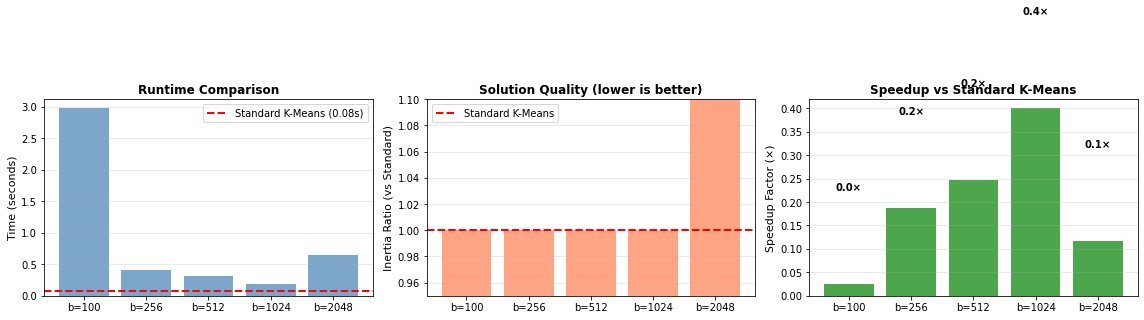


📊 Summary:
 batch_size     time       inertia  silhouette
        100 2.972161  72639.343863    0.702508
        256 0.407346  72663.928544    0.702508
        512 0.309211  72650.185248    0.702508
       1024 0.190525  72645.860756    0.702508
       2048 0.648580 179682.515366    0.496307

💡 With batch_size=256, we get 0.2× speedup
   with only 0.0% increase in inertia


In [5]:
# Mini-Batch K-Means demonstration

# Generate large dataset
n_large = 100000
X_large, y_large = make_blobs(n_samples=n_large, n_features=10, 
                               centers=5, random_state=42)
X_large = StandardScaler().fit_transform(X_large)

# Compare K-Means vs Mini-Batch K-Means
batch_sizes = [100, 256, 512, 1024, 2048]
results_mb = {'batch_size': [], 'time': [], 'inertia': [], 'silhouette': []}

# Standard K-Means (baseline)
print("Running standard K-Means (this may take a moment)...")
start = time.time()
km_standard = KMeans(n_clusters=5, n_init=1, max_iter=100, random_state=42).fit(X_large)
km_time = time.time() - start
km_inertia = km_standard.inertia_
km_sil = silhouette_score(X_large[:10000], km_standard.labels_[:10000])  # Sample for speed

print(f"Standard K-Means: {km_time:.2f}s, Inertia: {km_inertia:.0f}")

# Mini-Batch K-Means
for batch_size in batch_sizes:
    start = time.time()
    mb_km = MiniBatchKMeans(n_clusters=5, batch_size=batch_size, 
                            n_init=1, max_iter=100, random_state=42).fit(X_large)
    elapsed = time.time() - start
    
    results_mb['batch_size'].append(batch_size)
    results_mb['time'].append(elapsed)
    results_mb['inertia'].append(mb_km.inertia_)
    results_mb['silhouette'].append(silhouette_score(X_large[:10000], mb_km.labels_[:10000]))

mb_df = pd.DataFrame(results_mb)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Runtime comparison
ax = axes[0]
ax.bar(range(len(batch_sizes)), mb_df['time'], color='steelblue', alpha=0.7)
ax.axhline(y=km_time, color='red', linestyle='--', linewidth=2, label=f'Standard K-Means ({km_time:.2f}s)')
ax.set_xticks(range(len(batch_sizes)))
ax.set_xticklabels([f'b={b}' for b in batch_sizes])
ax.set_ylabel('Time (seconds)', fontsize=11)
ax.set_title('Runtime Comparison', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Inertia (quality) comparison
ax = axes[1]
inertia_ratio = mb_df['inertia'] / km_inertia
ax.bar(range(len(batch_sizes)), inertia_ratio, color='coral', alpha=0.7)
ax.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Standard K-Means')
ax.set_xticks(range(len(batch_sizes)))
ax.set_xticklabels([f'b={b}' for b in batch_sizes])
ax.set_ylabel('Inertia Ratio (vs Standard)', fontsize=11)
ax.set_title('Solution Quality (lower is better)', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0.95, 1.1)

# Speedup factor
ax = axes[2]
speedup = km_time / mb_df['time']
ax.bar(range(len(batch_sizes)), speedup, color='green', alpha=0.7)
ax.set_xticks(range(len(batch_sizes)))
ax.set_xticklabels([f'b={b}' for b in batch_sizes])
ax.set_ylabel('Speedup Factor (×)', fontsize=11)
ax.set_title('Speedup vs Standard K-Means', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

for i, s in enumerate(speedup):
    ax.text(i, s + 0.2, f'{s:.1f}×', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 Summary:")
print(mb_df.to_string(index=False))
print(f"\n💡 With batch_size=256, we get {km_time/mb_df[mb_df['batch_size']==256]['time'].values[0]:.1f}× speedup")
print(f"   with only {(mb_df[mb_df['batch_size']==256]['inertia'].values[0]/km_inertia - 1)*100:.1f}% increase in inertia")

----------------------
**BIRCH: The "Summarize and Conquer" Algorithm**

*Balanced Iterative Reducing and Clustering using Hierarchies*

Imagine you are organizing a massive library.

* **The Hard Way (K-Means):** You write down the full text of every single book. (Impossible!)
* **The BIRCH Way:** You just write a tiny **index card** for each shelf (e.g., "Shelf A: 20 books, mostly History").

BIRCH does not memorize every data point. It builds a **Tree of Summaries** (called the **CF Tree**). It groups similar data into little blobs and only remembers the statistics of the blob, not the individual dots.


For every blob of data, BIRCH keeps a "Summary Card" with just **3 numbers**:

1. **Count ():** How many points are in this blob?
2. **Sum ():** Where is the center of the blob?
3. **Squared Sum ():** How big (spread out) is the blob?

**The Magic Trick:**
You can merge two blobs just by adding their numbers on a calculator. You don't need to look at the original data again.

**Why is it good?**

| Feature | Simple Explanation |
| --- | --- |
| **Super Fast** | It reads your data only **once** (like reading a book cover-to-cover one time). |
| **Low Memory** | It works even if your computer has small RAM. It only stores the "Summary Cards," not the full data. |
| **Updatable** | Got new data? Just add it to the tree. No need to restart from scratch. |
| **Clean** | If a blob has only 1 or 2 points, BIRCH assumes it's a mistake (noise) and deletes it. |

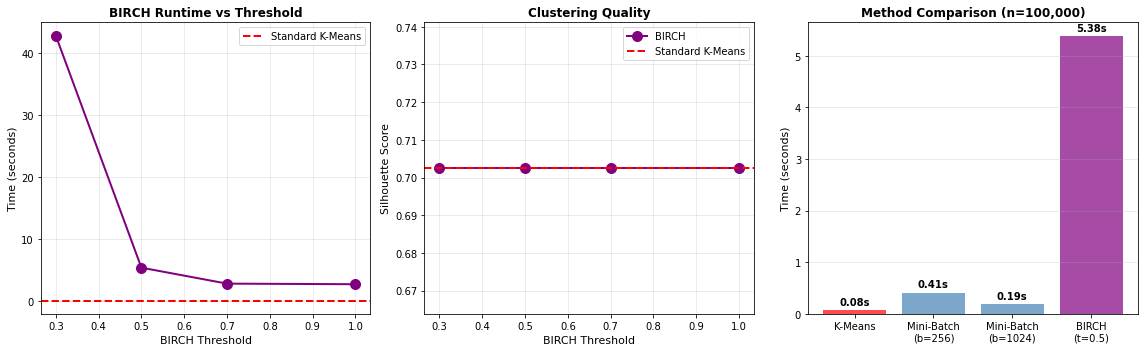


📊 BIRCH Summary:
 threshold      time  n_clusters  silhouette
       0.3 42.770925           5    0.702508
       0.5  5.377947           5    0.702508
       0.7  2.804814           5    0.702508
       1.0  2.708475           5    0.702508


In [6]:
# BIRCH demonstration

# Compare BIRCH with K-Means on large data
threshold_values = [0.3, 0.5, 0.7, 1.0]
results_birch = {'threshold': [], 'time': [], 'n_clusters': [], 'silhouette': []}

for threshold in threshold_values:
    start = time.time()
    birch = Birch(n_clusters=5, threshold=threshold).fit(X_large)
    elapsed = time.time() - start
    
    results_birch['threshold'].append(threshold)
    results_birch['time'].append(elapsed)
    results_birch['n_clusters'].append(len(np.unique(birch.labels_)))
    results_birch['silhouette'].append(silhouette_score(X_large[:10000], birch.labels_[:10000]))

birch_df = pd.DataFrame(results_birch)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Runtime
ax = axes[0]
ax.plot(birch_df['threshold'], birch_df['time'], 'o-', linewidth=2, markersize=10, color='purple')
ax.axhline(y=km_time, color='red', linestyle='--', linewidth=2, label='Standard K-Means')
ax.set_xlabel('BIRCH Threshold', fontsize=11)
ax.set_ylabel('Time (seconds)', fontsize=11)
ax.set_title('BIRCH Runtime vs Threshold', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Quality comparison
ax = axes[1]
ax.plot(birch_df['threshold'], birch_df['silhouette'], 'o-', linewidth=2, markersize=10, color='purple', label='BIRCH')
ax.axhline(y=km_sil, color='red', linestyle='--', linewidth=2, label='Standard K-Means')
ax.set_xlabel('BIRCH Threshold', fontsize=11)
ax.set_ylabel('Silhouette Score', fontsize=11)
ax.set_title('Clustering Quality', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# All methods comparison
ax = axes[2]
methods = ['K-Means', 'Mini-Batch\n(b=256)', 'Mini-Batch\n(b=1024)', 'BIRCH\n(t=0.5)']
times = [km_time, 
         mb_df[mb_df['batch_size']==256]['time'].values[0],
         mb_df[mb_df['batch_size']==1024]['time'].values[0],
         birch_df[birch_df['threshold']==0.5]['time'].values[0]]
colors = ['red', 'steelblue', 'steelblue', 'purple']

bars = ax.bar(methods, times, color=colors, alpha=0.7)
ax.set_ylabel('Time (seconds)', fontsize=11)
ax.set_title(f'Method Comparison (n={n_large:,})', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

for bar, t in zip(bars, times):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
            f'{t:.2f}s', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 BIRCH Summary:")
print(birch_df.to_string(index=False))

----------------------------------
## When to Consider Spark

<img src="https://media.licdn.com/dms/image/v2/C5622AQHDVAeCmQnz7Q/feedshare-shrink_2048_1536/feedshare-shrink_2048_1536/0/1650475920183?e=2147483647&v=beta&t=3Zbo5llrIObkZE1jcvizIuOmSIcW2vRY71RiinOl42o
" width="285" height="155" />

When data exceeds the memory of a single machine, or when you need to process data across a cluster, **Apache Spark** becomes essential.


| Algorithm | Spark Support | Notes |
|-----------|--------------|-------|
| K-Means | ✅ Full | Parallel Lloyd's algorithm |
| Bisecting K-Means | ✅ Full | Hierarchical, often faster |
| GMM | ✅ Full | Distributed EM |
| LDA | ✅ Full | Topic modeling |
| DBSCAN | ⚠️ Limited | Available via external libraries |

**How Spark K-Means Works**

1. **Data partitioning:** Data is distributed across worker nodes
2. **Local assignment:** Each worker assigns its local points to centroids
3. **Local aggregation:** Each worker computes partial sums for centroid updates
4. **Global aggregation:** Driver combines partial sums to compute new centroids
5. **Broadcast:** New centroids are broadcast to all workers

```
           ┌─────────────────────────────────────────┐
           │              Driver Node                │
           │   - Initialize centroids                │
           │   - Aggregate partial sums              │
           │   - Compute new centroids               │
           │   - Check convergence                   │
           └────────────────┬────────────────────────┘
                            │ broadcast centroids
              ┌─────────────┼─────────────┐
              ▼             ▼             ▼
        ┌──────────┐  ┌──────────┐  ┌──────────┐
        │ Worker 1 │  │ Worker 2 │  │ Worker 3 │
        │ - Local  │  │ - Local  │  │ - Local  │
        │   assign │  │   assign │  │   assign │
        │ - Partial│  │ - Partial│  │ - Partial│
        │   sums   │  │   sums   │  │   sums   │
        └──────────┘  └──────────┘  └──────────┘
```